# imports

In [1]:
import os
import numpy
import numpy as np
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from glob import glob
from tqdm import tqdm

import tensorflow as tf
from keras import layers
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras.optimizers import Adam

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, RobustScaler, Normalizer

if not os.path.exists('./models'):
  os.makedirs('./models')

Using TensorFlow backend.


## read csv
se separa los datos a un archivo .csv para una mejor lectura

In [2]:
data = pd.read_csv('data.csv', sep=';')
data.pop('Case')

0        1
1        2
2        3
3        4
4        5
      ... 
101    102
102    103
103    104
104    105
105    106
Name: Case, Length: 106, dtype: int64

# data analysis
106 datos con 11 valores
uno de ellos es el numero del dato, por lo cual se descarta
otro es la clase por lo que tendriamos
1 columna de clase y las 9 de caracteristicas

Para realizar machine learning es necesario saber de donde vienen los datos
como se obtuvieron, y que signfica cada clase
Junto con los datos esta su paper, el cual describe los datos

indica lo siguiente:

  las clases:
    con: 14 casos
    adi: 22 casos
    gla: 16 casos
    car: 21 casos
    fad: 15 casos
    mas: 18 casos

  con lo anterior se puede inferir que se enfrenta a datos un poco desbalanceados

  "El conjunto de datos inicial consistió en 120 espectros registrados en
  muestras de tejido mamario de 64 pacientes sometidas a cirugía mamaria.
  Cada espectro consistió en doce mediciones de impedancia tomadas a
  diferentes frecuencias que van desde 488 Hz a 1 MHz. Los detalles sobre
  el procedimiento de recopilación de datos, así como la clasificación de
  los casos y las frecuencias utilizadas se proporcionan en otra parte
  (JosSrNET, 1996; JOSSINET, 1998). Antes de cualquier intento de
  clasificación, se descartaron 14 espectros ya que exhibían características
  manifiestamente anormales (error de entrada, baja D A) debido a la mala
  atención de la recolección de tejido y / o medición de datos."

  Esto significa que son mediciones medicas de otro paper, y que se descartaron
  14 por su anormalidad frente a los demas datos. Por otro lado la poca cantidad
  de datos recolectados (referente al area de salud) el resultado de cualquier
  clasificacion puede ser erronea frente a un nuevo caso

  Por lo tanto: El modelo generado aqui es solo de investigacion, No usar en
  pacientes.

In [3]:
print(data.shape)

num_class = len(list(set(data['Class'])))

(106, 10)


# Figuras
En la siguiente imagen se muestra una imagen muy similar a la Figura 3.a y a la Figura 3.b con distintos margenes

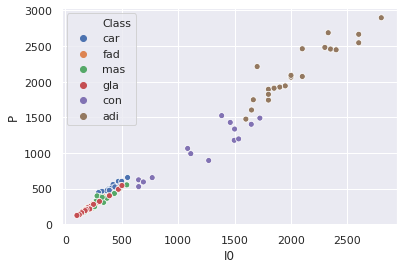

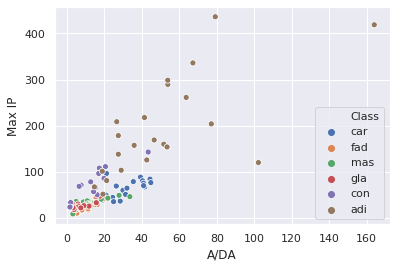

In [4]:
sns.scatterplot(x="I0", y="P", hue="Class",  data=data)
plt.show()
sns.scatterplot(x="A/DA", y="Max IP", hue="Class",  data=data)
plt.show()

## Otras figuras interesantes
en esta se visualiza una separacion de las clases, no es muy grande, pero
 se puede distinguir las secciones y un dato que sobre sale a la derecha


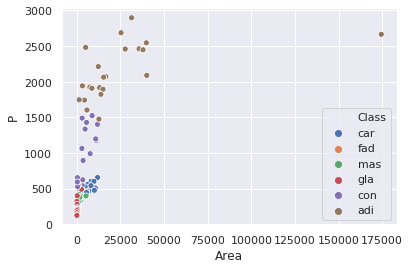

In [5]:
sns.scatterplot(x="Area", y="P", hue="Class",  data=data)
plt.show()

En la siguiente imagen se puede encontrar una anomalia en un dato de la clase
 adi lo ideal es eliminarlo, ya que puede quebrar todo# intento de normalizar los datos.

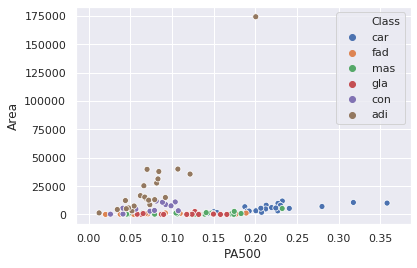

In [6]:
sns.scatterplot(x="PA500", y="Area", hue="Class",  data=data)
plt.show()

Gracias a los graficos anteriores se descarta la normalizacion de 0 a 1,
 la propuesta es normalizar a traves del promedio y la desviacion estandar
 
las clases adi, car y con son las mas faciles de clasificar, el dominio donde
rondan se puede ver claramente, por lo que no tendra problemas el clasificador
 en clasificar estas 3 clases, el problema radica con la clase gla y mas
 que en cada grafico aparecen muy juntos, esto significa 2 cosas:
 No se puede utilizar un modelo muy simple ni tan complejo, ya que puede pasar
 el underfitting y el overfitting
 el otro

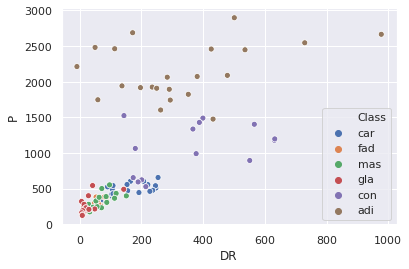

In [7]:
sns.scatterplot(x="DR", y="P", hue="Class",  data=data)
plt.show()

## data pre-processing
Se pre-procesan los datos, distintos tipos de normalizacion


In [8]:
le = LabelEncoder()
le.fit(data['Class'].values)
integer_encoded = le.transform(data['Class'].values)
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

# le.inverse_transform(integer_encoded)

#elimina los datos que nos son caracteristicas
target_names = data['Class'].values
data.pop('Class')


num_inputs = data.shape[-1]

def scaler_none(data: numpy.ndarray):
  '''
  No realiza ningun cambio a los datos

  Parameters
  ----------
  data : numpy.ndarray
    Datos de entrada.

  Returns
  -------
  scaler : object
    Escalador para transformar los datos.
  x_train : numpy.ndarray
    Datos transformados.

  '''
  class Scaler:
    def inverse_transform(self, X):
      return X
  scaler = Scaler()
  x_train = np.array(data)
  return scaler, x_train

def minMaxScaler(data: numpy.ndarray):
  '''
  Este estimador escala y traduce cada característica individualmente de modo
  que esté en el rango dado en el conjunto de entrenamiento entre cero y uno

  Parameters
  ----------
  data : numpy.ndarray
    Datos de entrada.

  Returns
  -------
  scaler : MinMaxScaler
    Escalador para transformar los datos.
  x_train : numpy.ndarray
    Datos transformados.

  '''
  scaler = MinMaxScaler()
  x_train = scaler.fit_transform(data)

  return scaler, x_train



 ## data split
 La data data split sera siempre la misma (para probar siempre los mismo datos
 independiente del tiempo) con random_state = 1

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
  data.values, onehot_encoded, test_size=0.3)

# Modelos

In [10]:
def model_complex(batch_norm=False):
  '''
  Se comprueba la hipotesis anterior con un modelo complejo
  deberia de obtener una tasa de error muy baja pero en los datos validacion
  muy pobre

  Parameters
  ----------
  batch_norm : boolean, optional
    añade una capa de batch normalization. The default is False.

  Returns
  -------
  keras.engine.training.Model

  '''
  inputs = layers.Input([num_inputs])
  x = layers.Dense(48, activation='sigmoid',
                   kernel_initializer='orthogonal')(inputs)

  x = layers.Dense(64, activation='relu',
                   kernel_initializer='orthogonal')(x)

  x = layers.Dense(num_class * 2, activation='relu',
                   kernel_initializer='orthogonal')(x)

  out = layers.Dense(num_class, activation='softmax',)(x)

  model = Model(inputs, out)

  model.compile(loss='categorical_hinge', optimizer=Adam(1e-3),
                metrics=['acc'])

  return model

def model_very_complex(batch_norm=False):
  '''
  Para comprobar la hipotesis anterior de que si un modelo muy simple no es
  suficiente para clasificar correctamente los datos se utilizara un modelo
  perceptron

  Parameters
  ----------
  batch_norm : boolean, optional
    añade una capa de batch normalization. The default is False.

  Returns
  -------
  keras.engine.training.Model

  '''
  inputs = layers.Input([num_inputs])
  x = layers.Dense(num_inputs, activation='relu',
                   kernel_initializer='orthogonal')(inputs)

  x = layers.Dense(num_inputs * 2, activation='relu',
                   kernel_initializer='orthogonal')(x)

  x = layers.Dense(num_class * 4, activation='relu',
                   kernel_initializer='orthogonal')(x)

  x = layers.Dense(num_class * 2, activation='relu',
                   kernel_initializer='orthogonal')(x)

  out = layers.Dense(num_class, activation='softmax',)(x)

  model = Model(inputs, out)

  model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-3),
                metrics=['acc'])

  return model


def model_modest(batch_norm=False):
  '''
  Modelo ideal para este problema

  Parameters
  ----------
  batch_norm : boolean, optional
    añade una capa de batch normalization. The default is False.

  Returns
  -------
  keras.engine.training.Model

  '''

  inputs = layers.Input([num_inputs])
  x = layers.Dense(num_inputs, activation='sigmoid',
                   kernel_initializer='glorot_uniform')(inputs)

  out = layers.Dense(num_class, activation='sigmoid',
                    kernel_initializer='glorot_uniform')(x)

  model = Model(inputs, out)

  model.compile(loss='mse', optimizer=Adam(1e-3),
                metrics=['acc'])

  return model

## Define las variables para realizar bucle de cada prueba


In [11]:
# todos los escaladores a las caracteristicas
scalers = [minMaxScaler]
# los batch que se utilizaran
batchs = [8, 16, 32]#[len(X_train) // 10, len(X_train) // 20]
# las epocas a entrenar
epochs = [100, 500, 5000]#[100, 500]
# los modelos de red neuronal
models = [model_complex, model_very_complex, model_modest]
# k-fold a utilizar
cross_validations = [5, 7]

def plot_history(history, title):

  losses = list(np.copy(history.history['loss']))
  accs = list(np.copy(history.history['acc']))
  hue = ['train'] * len(history.history['loss'])

  losses.extend(history.history['val_loss'])
  accs.extend(history.history['val_acc'])
  hue.extend(['val'] * len(history.history['val_loss']))

  epoch = history.epoch
  epoch.extend(history.epoch)

  to_plot = pd.DataFrame(dict(
    epochs=epoch,
    losses=losses,
    accuracy=accs,
    dataset=hue,
    ))

  ax = sns.relplot(x="epochs", y="losses", hue="dataset", kind="line",
                   ci="sd", data=to_plot)
  ax.set(title=title)
  plt.show()
  ax = sns.relplot(x="epochs", y="accuracy", hue="dataset", kind="line",
                   ci="sd", data=to_plot)
  ax.set(title=title)
  plt.show()

## Estimadores
se realizan multiples pruebas para encontrar la mejor combinacion de parametros

  0%|          | 0/27 [00:00<?, ?it/s]

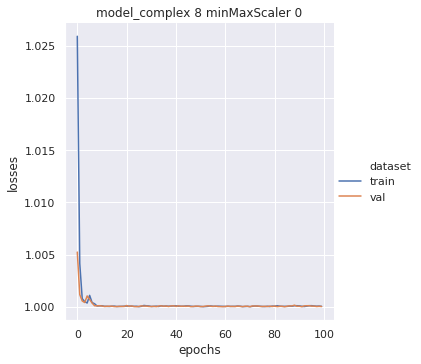

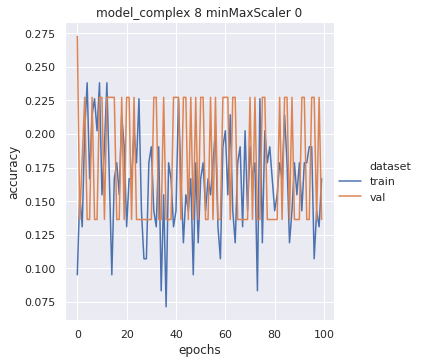

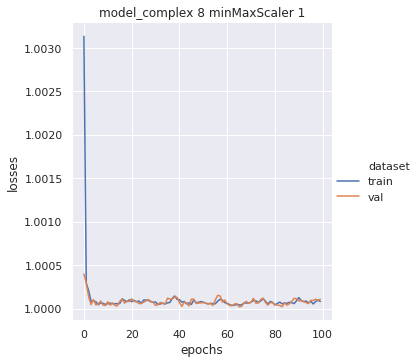

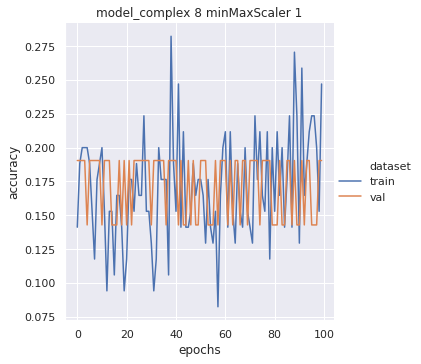

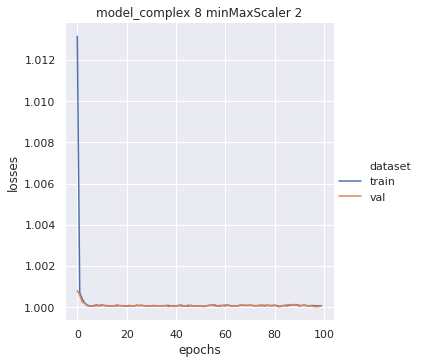

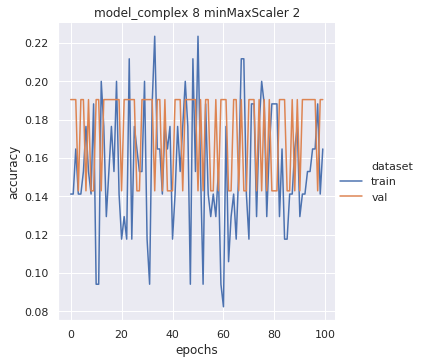

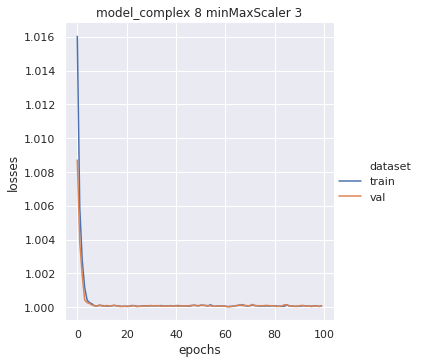

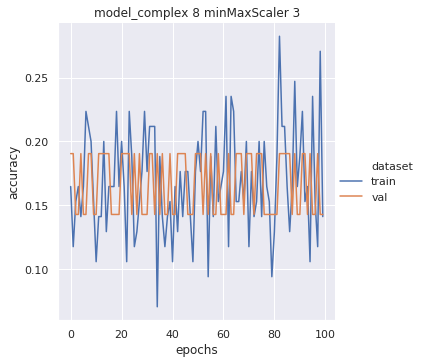

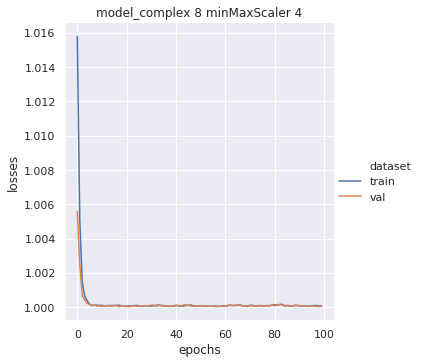

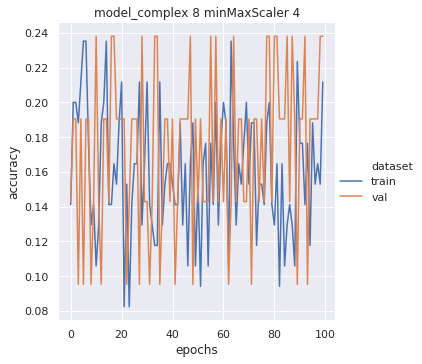

1/1 ; 1/3 ; 1/3 ; 1/3 ; 1/1:   4%|▎         | 1/27 [00:22<09:52, 22.80s/it]

	minMaxScaler	8	0.27272728085517883	0.2164502203464508	0.03364391324965262


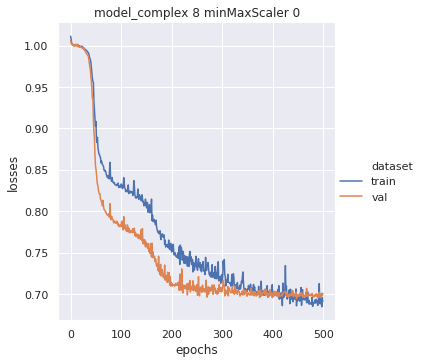

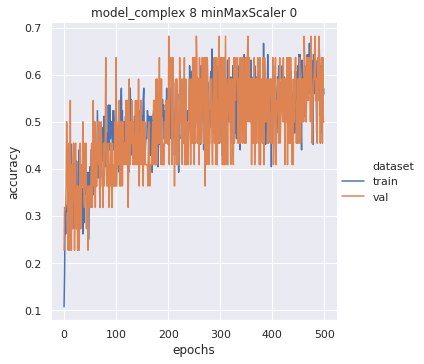

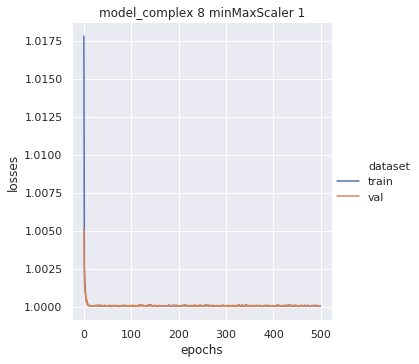

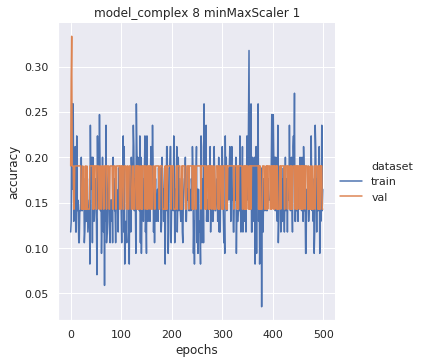

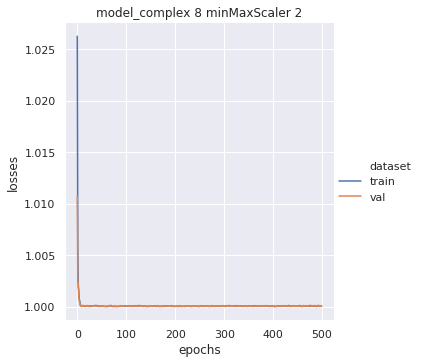

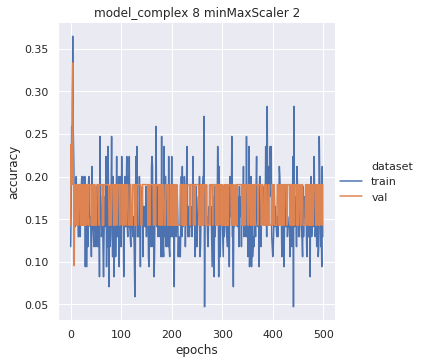

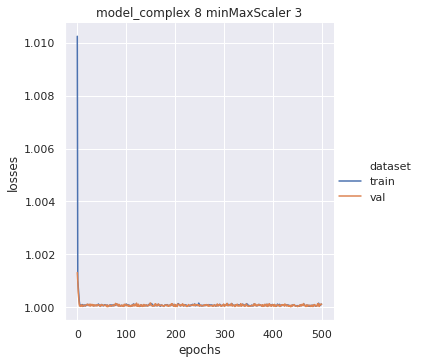

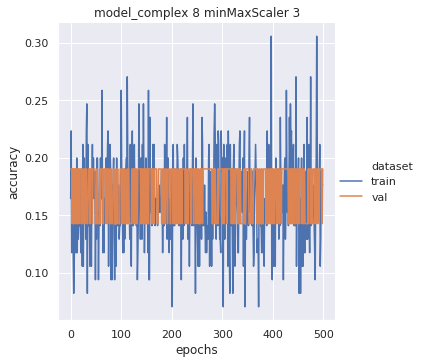

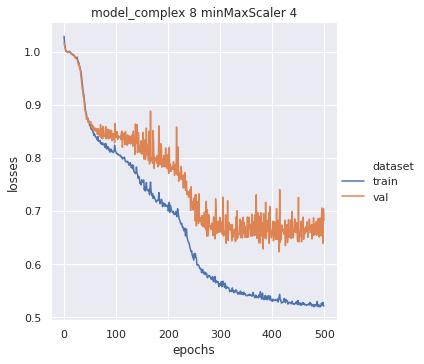

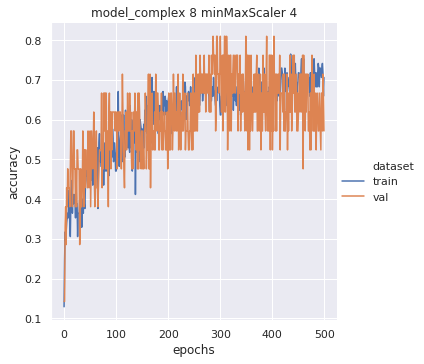

1/1 ; 1/3 ; 2/3 ; 1/3 ; 1/1:   7%|▋         | 2/27 [01:40<16:19, 39.18s/it]

	minMaxScaler	8	0.8095238208770752	0.46969697773456576	0.23479012692485618


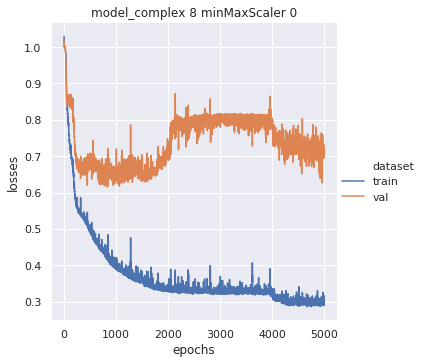

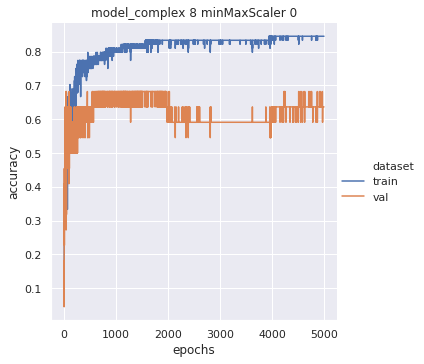

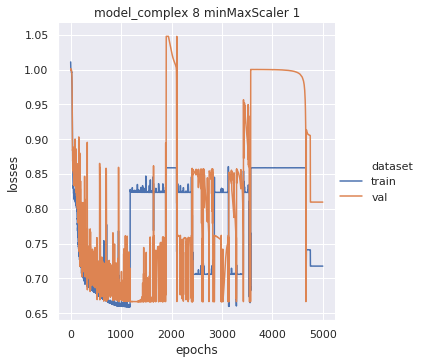

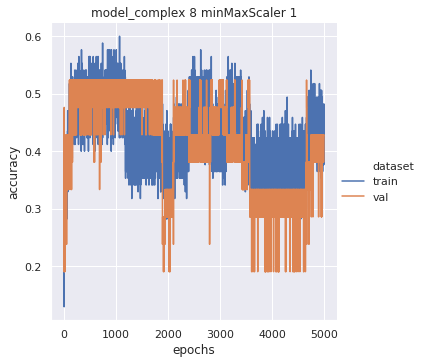

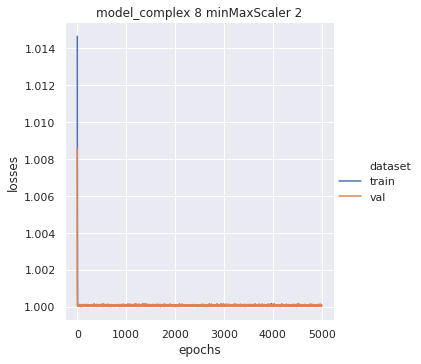

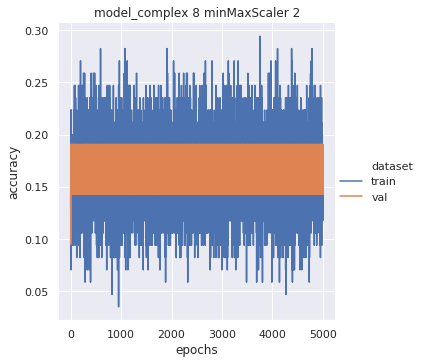

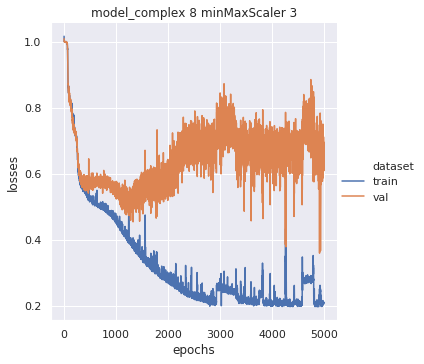

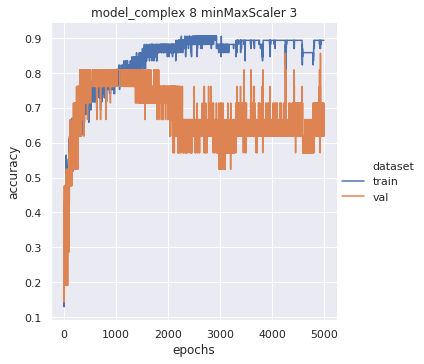

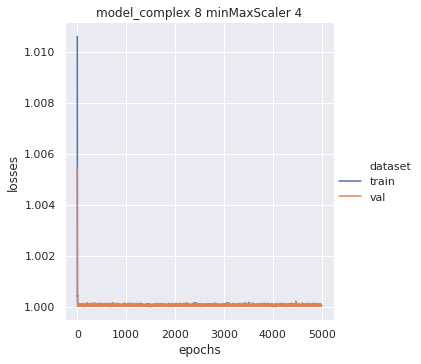

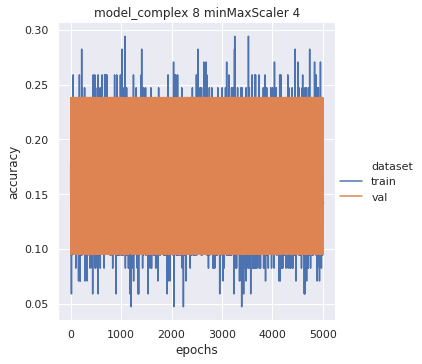

1/1 ; 1/3 ; 3/3 ; 1/3 ; 1/1:  11%|█         | 3/27 [12:37<1:29:50, 224.59s/it]

	minMaxScaler	8	0.8571428656578064	0.4982684075832367	0.2551704813715682


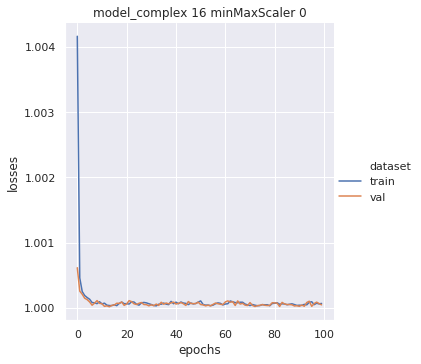

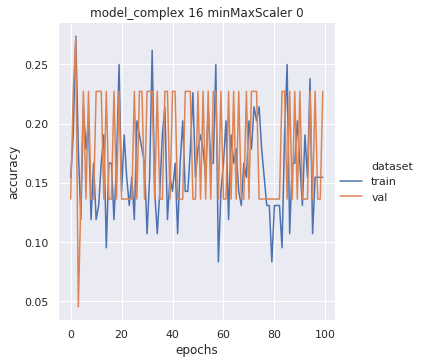

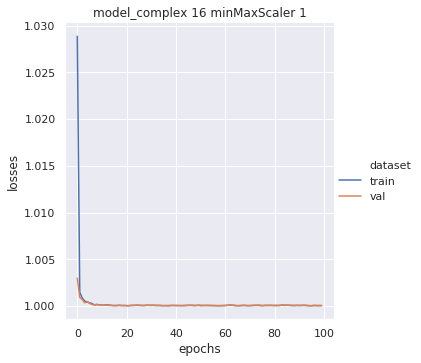

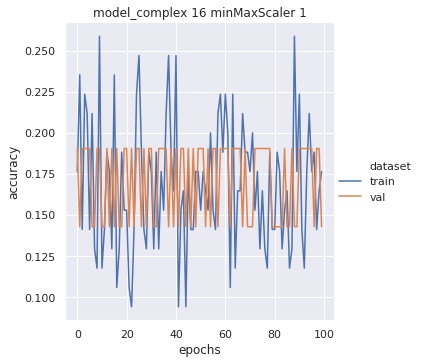

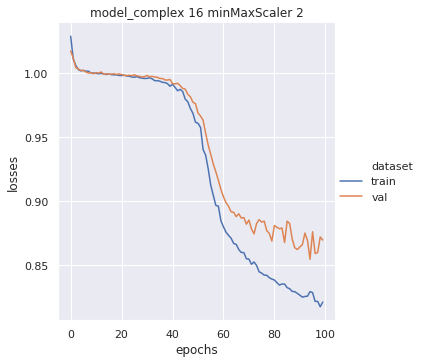

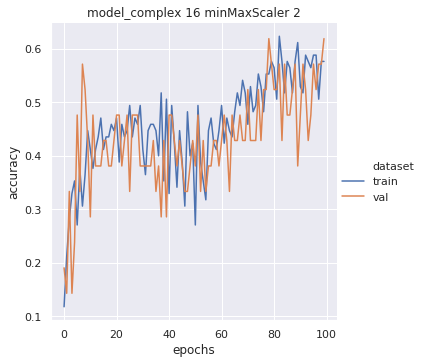

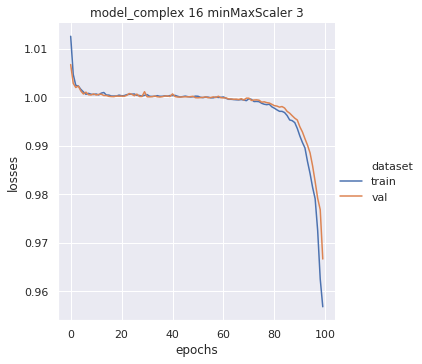

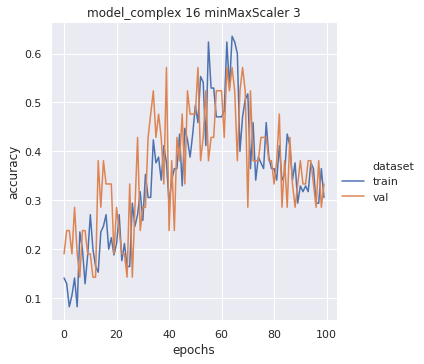

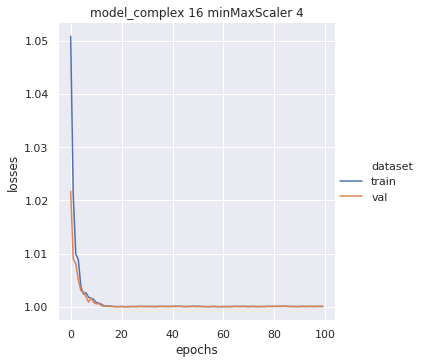

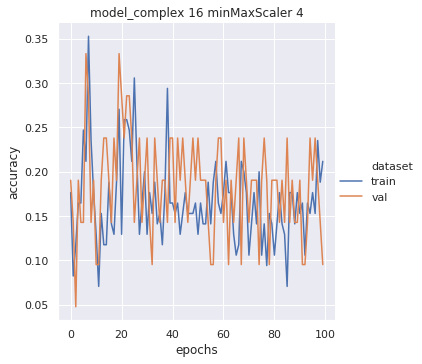

1/1 ; 2/3 ; 1/3 ; 1/3 ; 1/1:  15%|█▍        | 4/27 [12:55<1:02:17, 162.52s/it]

	minMaxScaler	16	0.6190476417541504	0.39740261137485505	0.16845112912000637


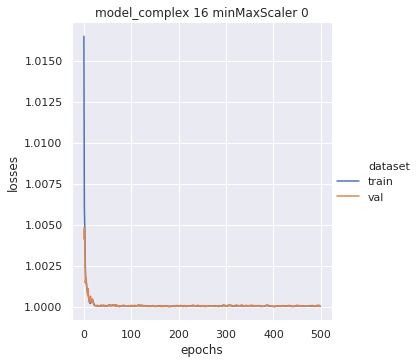

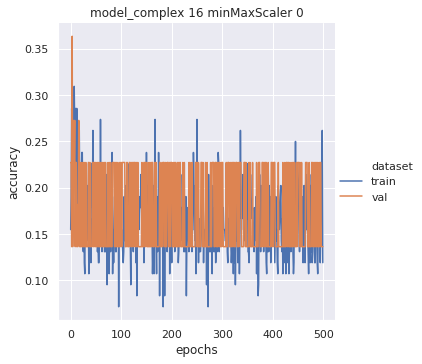

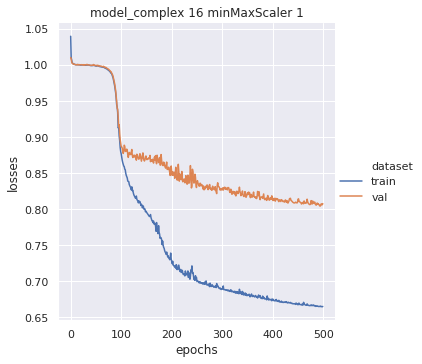

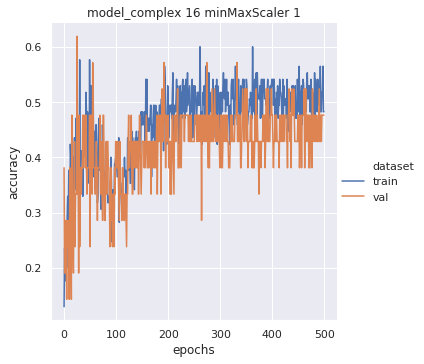

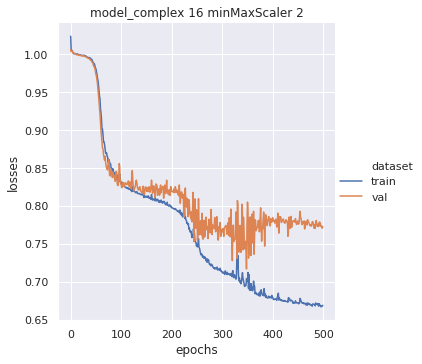

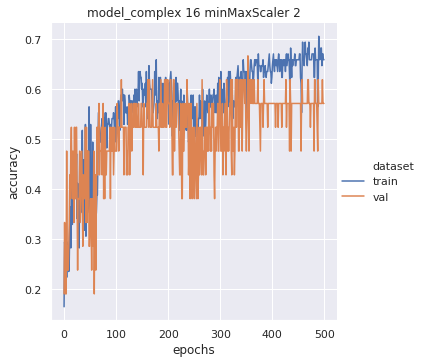

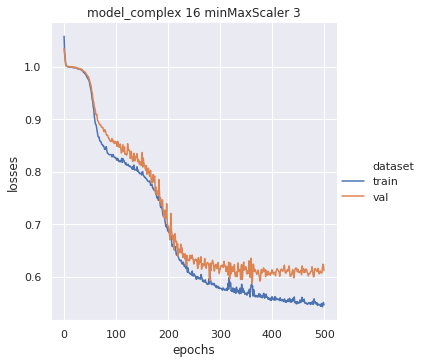

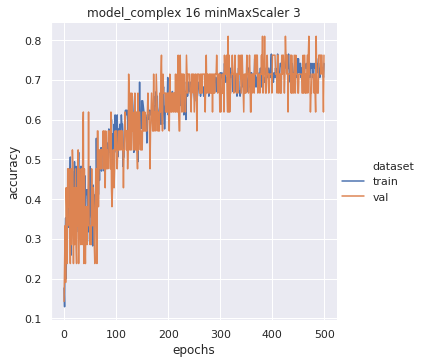

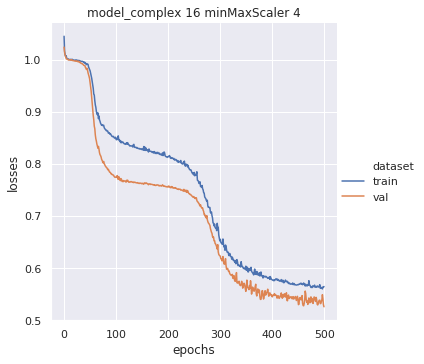

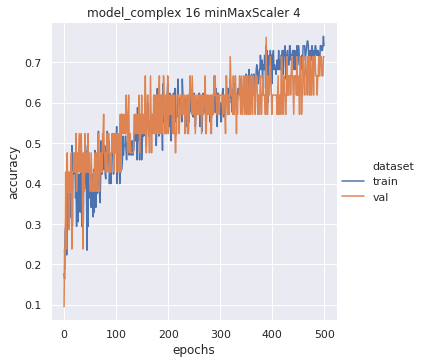

1/1 ; 2/3 ; 2/3 ; 1/3 ; 1/1:  19%|█▊        | 5/27 [13:51<47:57, 130.81s/it]  

	minMaxScaler	16	0.8095238208770752	0.6441558599472046	0.15558901723533217


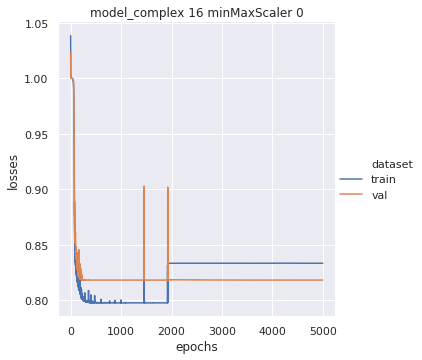

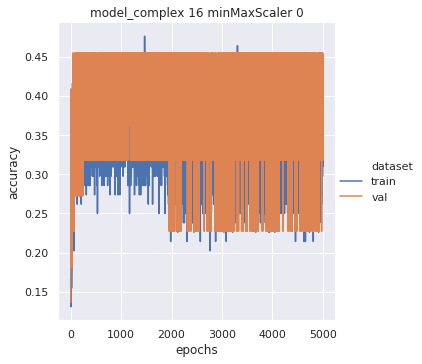

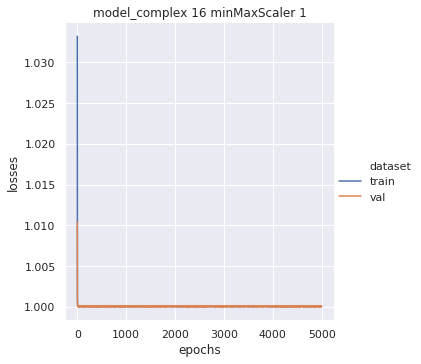

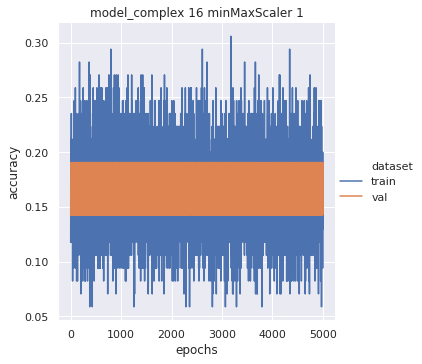

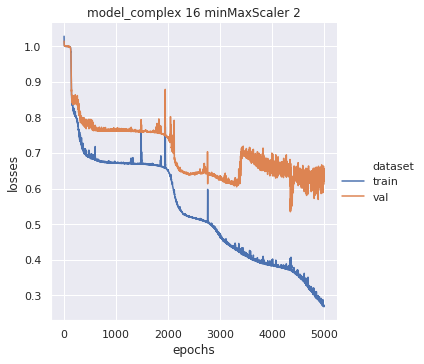

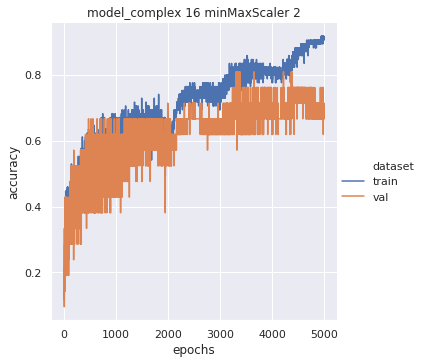

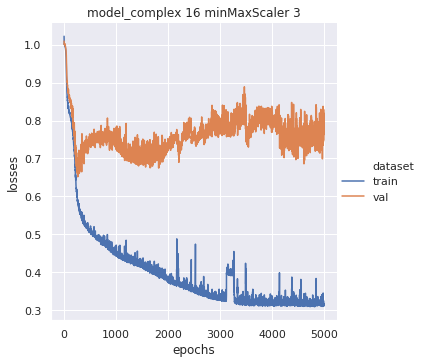

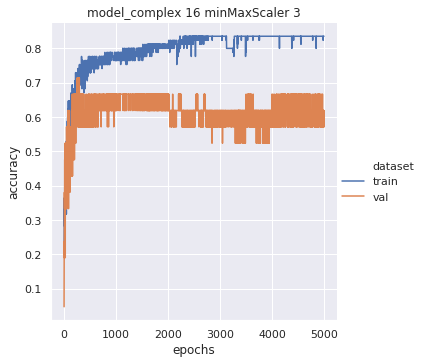

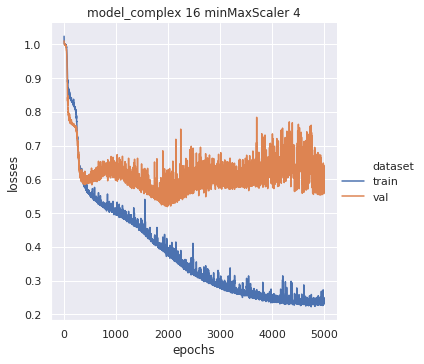

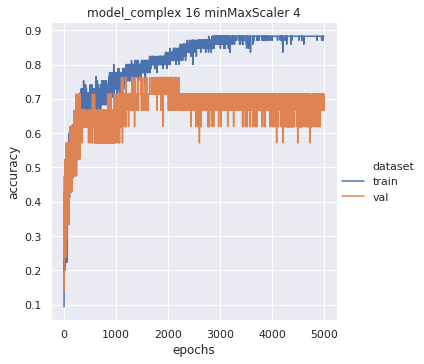

1/1 ; 2/3 ; 3/3 ; 1/3 ; 1/1:  22%|██▏       | 6/27 [20:23<1:13:11, 209.10s/it]

	minMaxScaler	16	0.8095238208770752	0.5861471980810166	0.23284410421079216


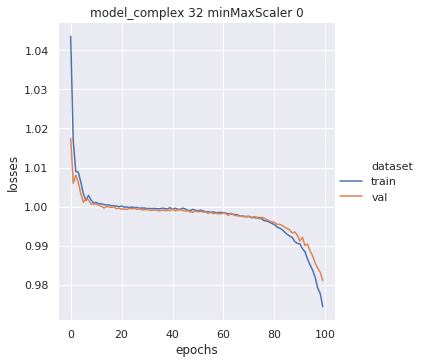

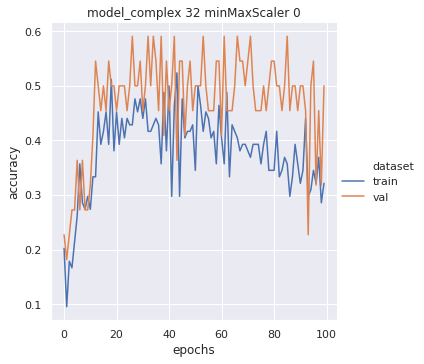

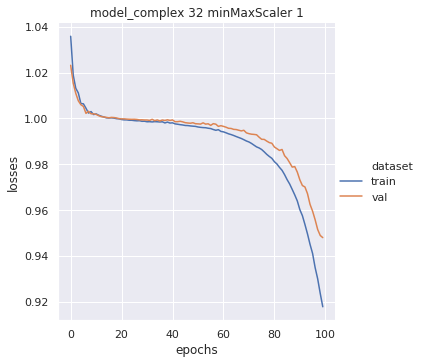

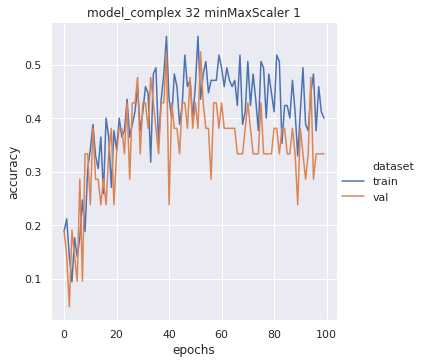

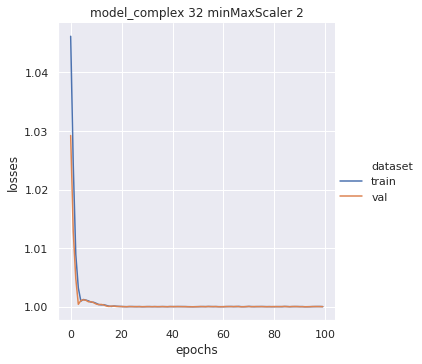

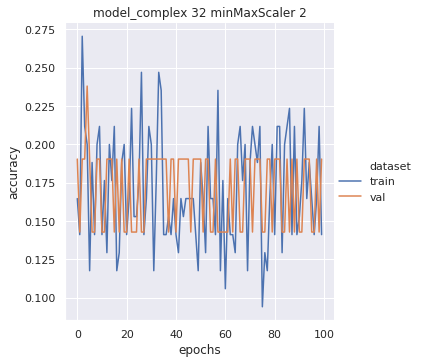

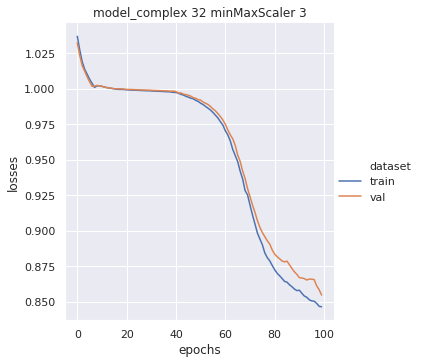

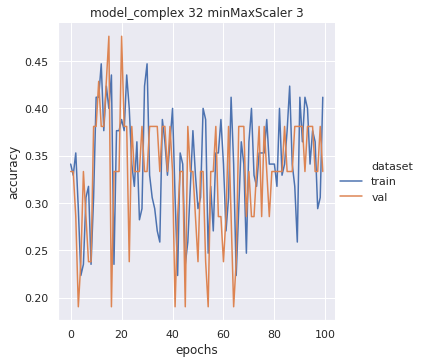

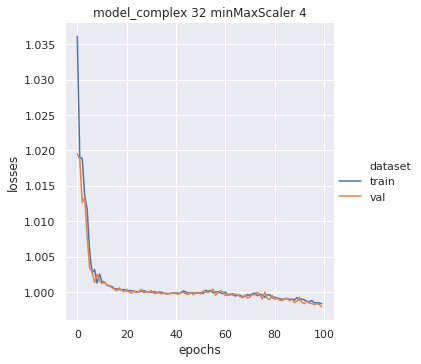

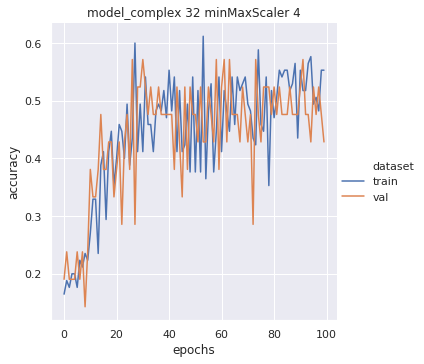

1/1 ; 3/3 ; 1/3 ; 1/3 ; 1/1:  26%|██▌       | 7/27 [20:40<50:25, 151.29s/it]  

	minMaxScaler	32	0.5909090638160706	0.48008658587932584	0.12736692985903178


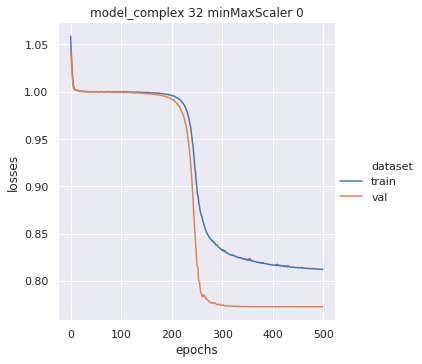

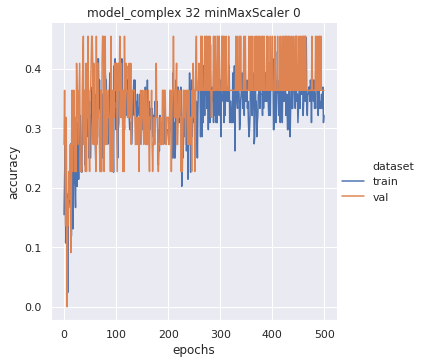

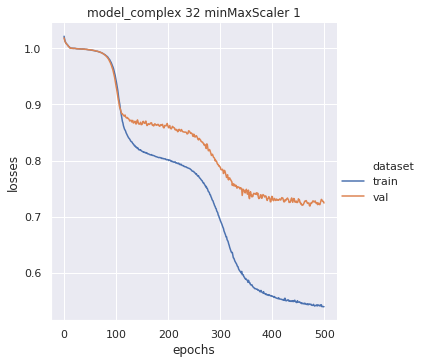

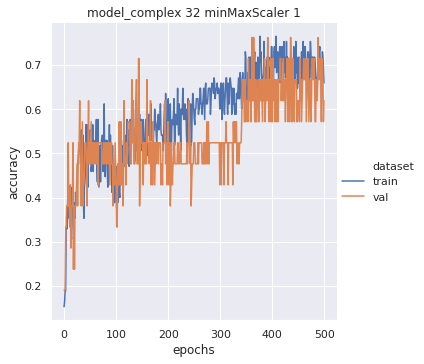

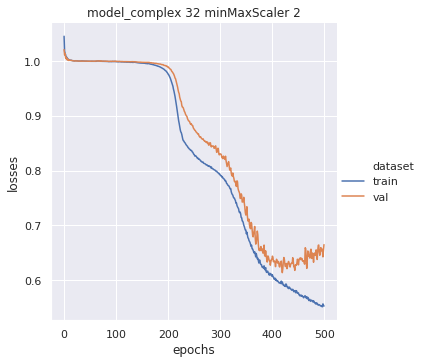

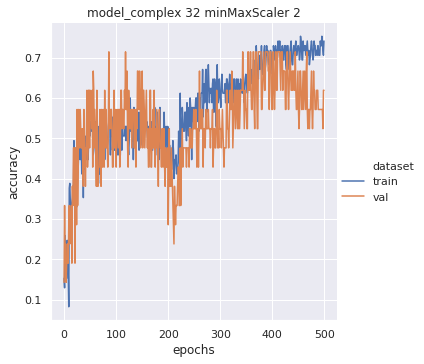

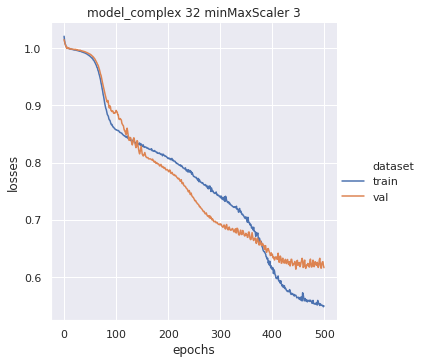

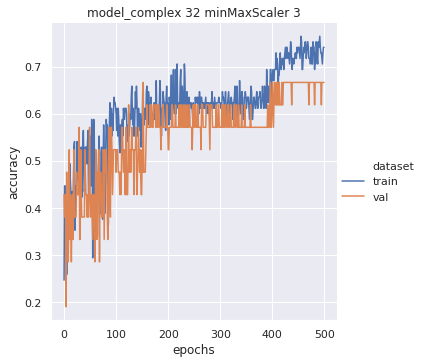

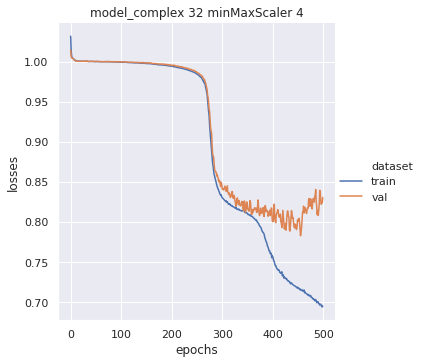

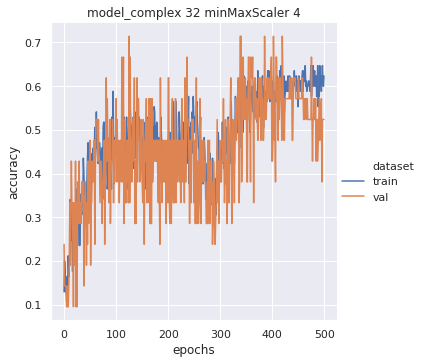

1/1 ; 3/3 ; 2/3 ; 1/3 ; 1/1:  30%|██▉       | 8/27 [21:28<38:06, 120.34s/it]

	minMaxScaler	32	0.761904776096344	0.6623376786708832	0.10817314853811971


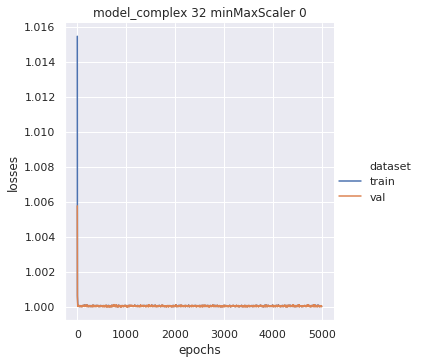

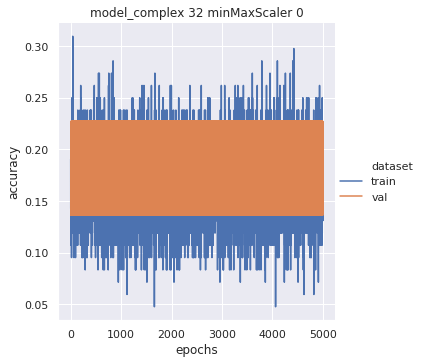

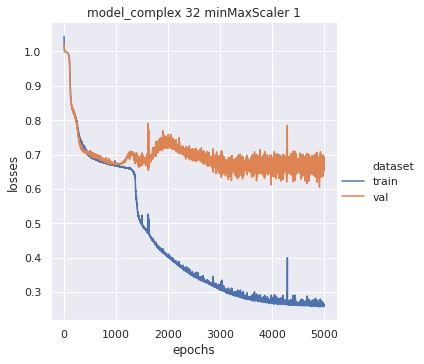

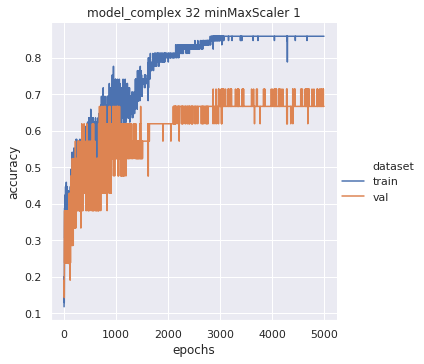

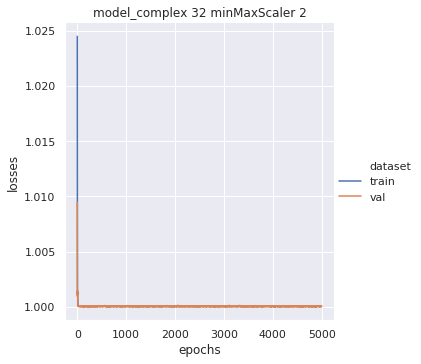

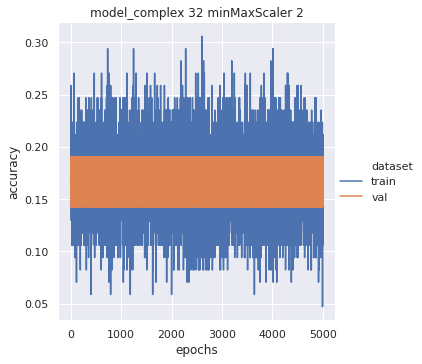

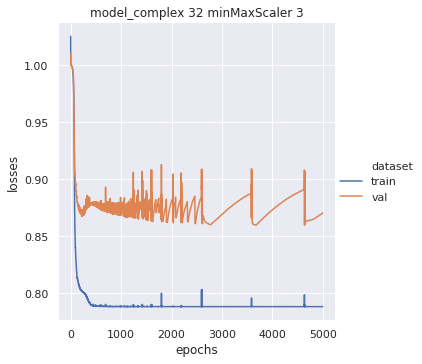

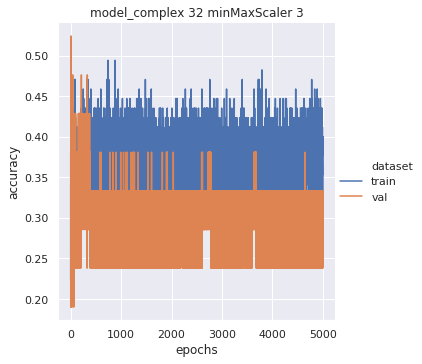

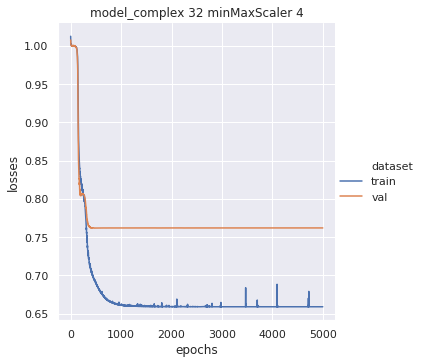

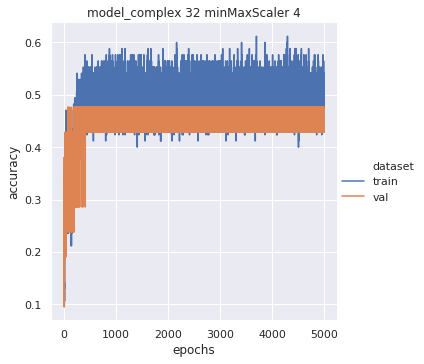

1/1 ; 3/3 ; 3/3 ; 1/3 ; 1/1:  33%|███▎      | 9/27 [25:11<45:23, 151.31s/it]

	minMaxScaler	32	0.7142857313156128	0.4264069378376007	0.19501672587032917


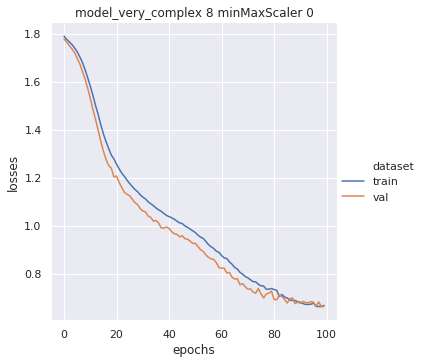

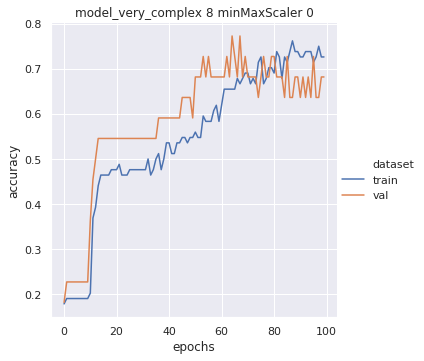

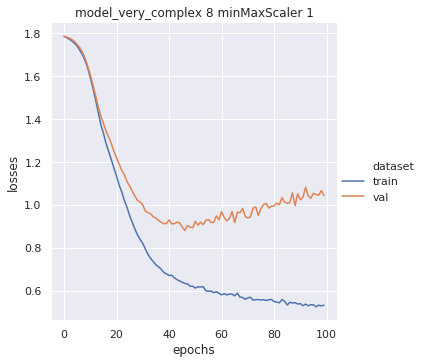

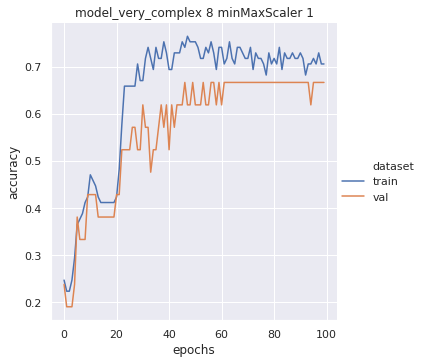

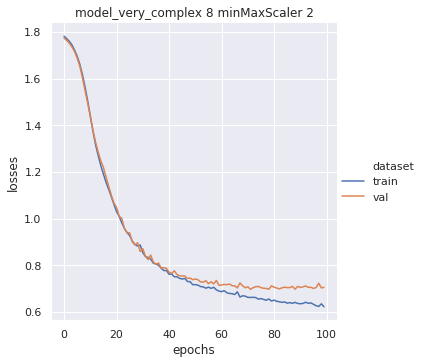

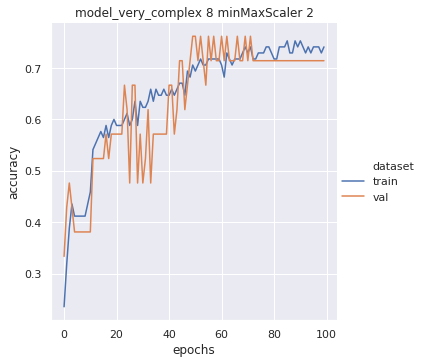

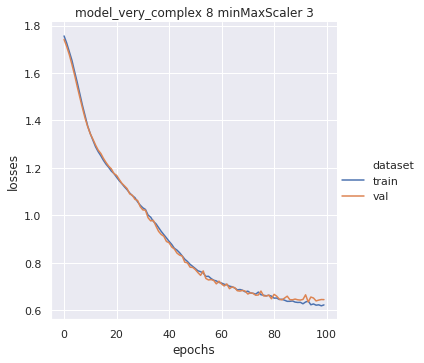

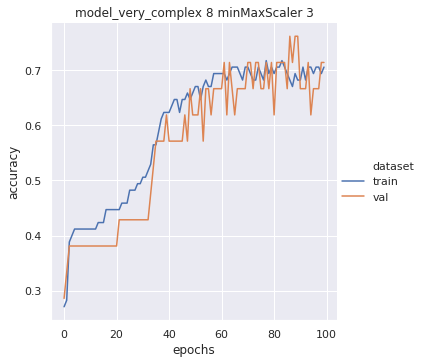

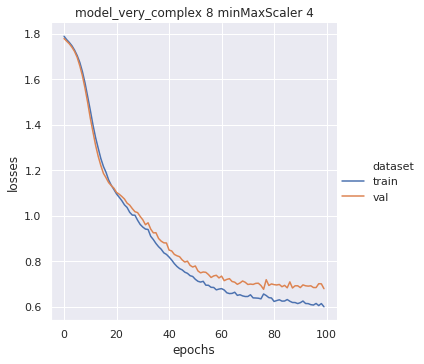

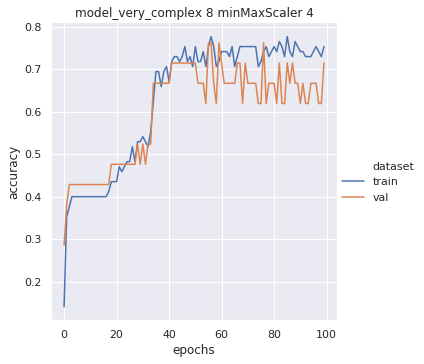

1/1 ; 1/3 ; 1/3 ; 2/3 ; 1/1:  37%|███▋      | 10/27 [25:44<32:45, 115.63s/it]

	minMaxScaler	8	0.7727272510528564	0.745021653175354	0.039401067167464346


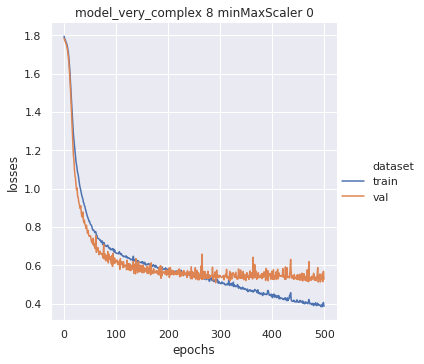

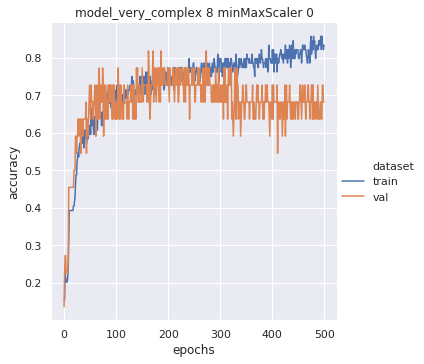

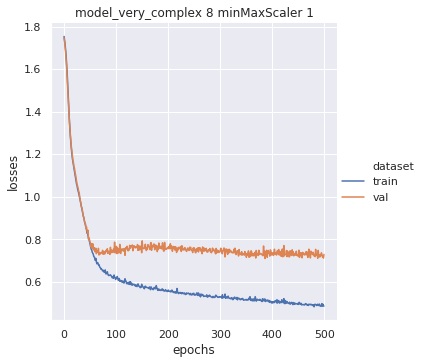

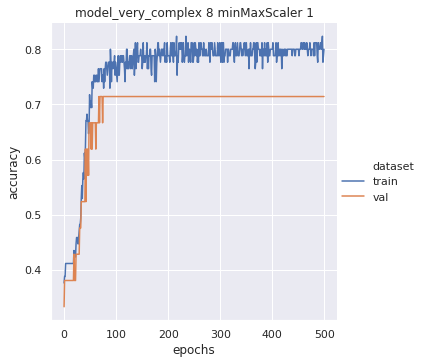

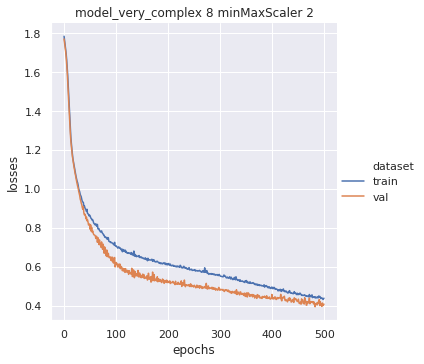

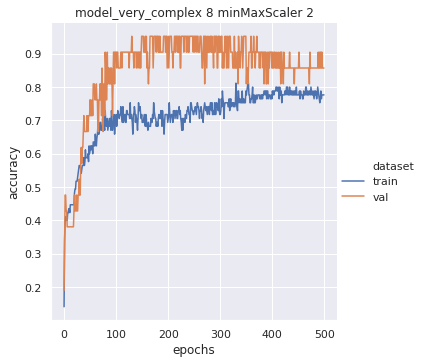

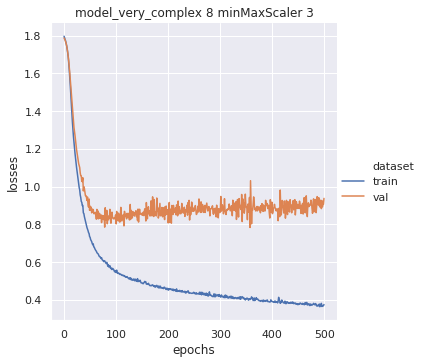

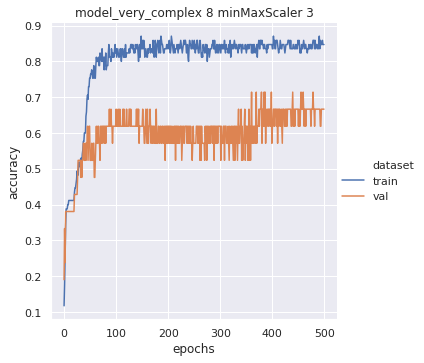

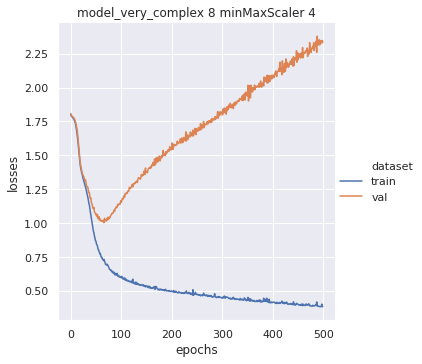

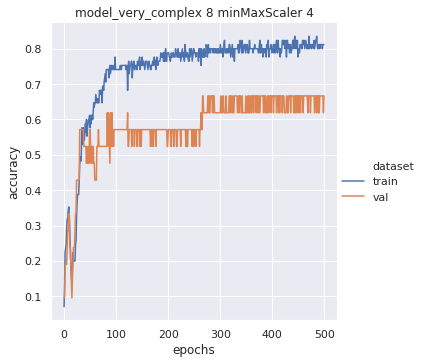

1/1 ; 1/3 ; 2/3 ; 2/3 ; 1/1:  41%|████      | 11/27 [27:13<28:46, 107.88s/it]

	minMaxScaler	8	0.9523809552192688	0.773160183429718	0.10239169815277763


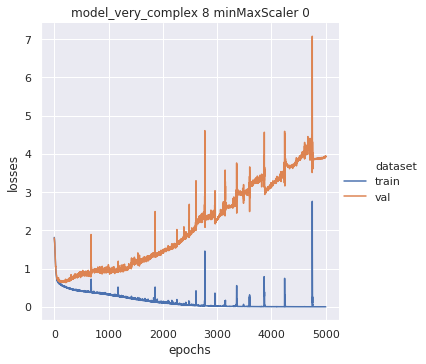

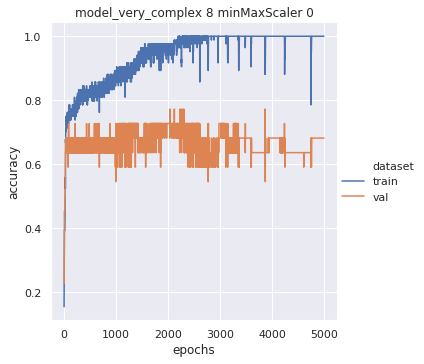

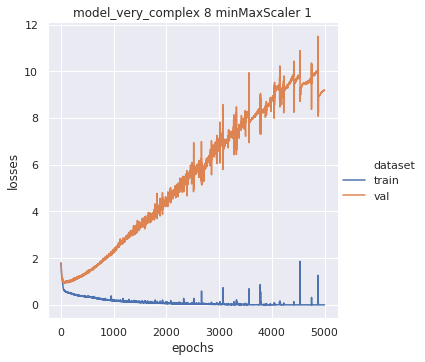

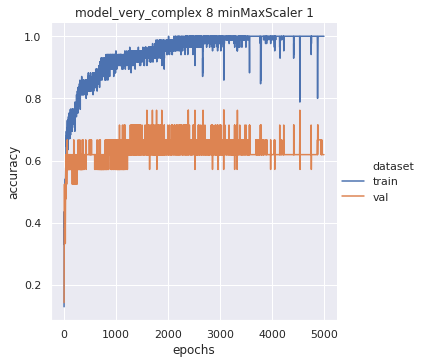

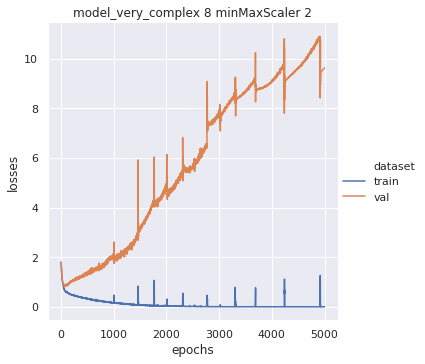

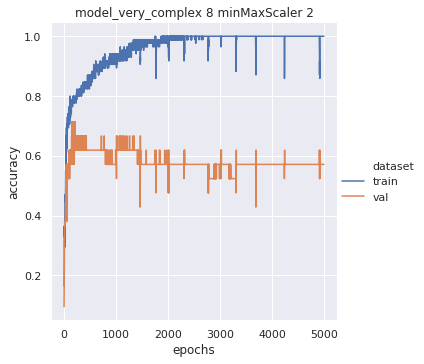

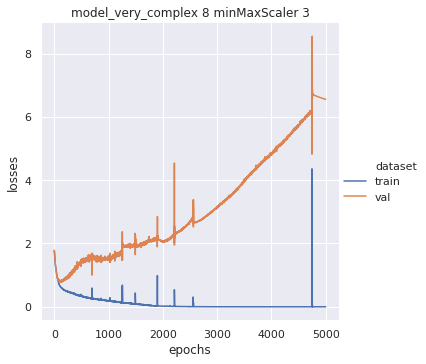

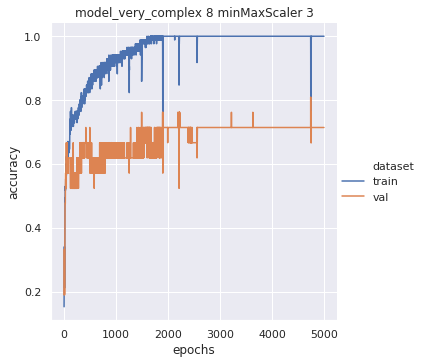

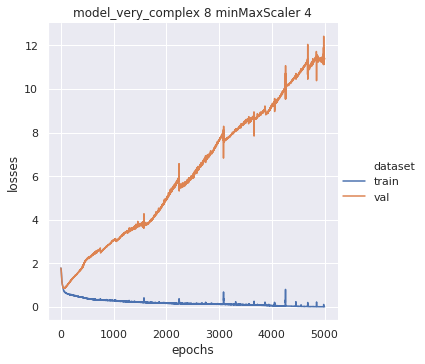

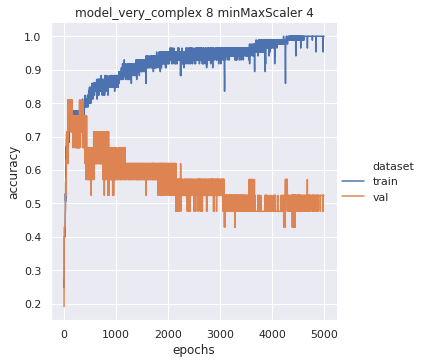

1/1 ; 1/3 ; 3/3 ; 2/3 ; 1/1:  44%|████▍     | 12/27 [38:59<1:11:46, 287.12s/it]

	minMaxScaler	8	0.8095238208770752	0.7735930800437927	0.03531788214441082


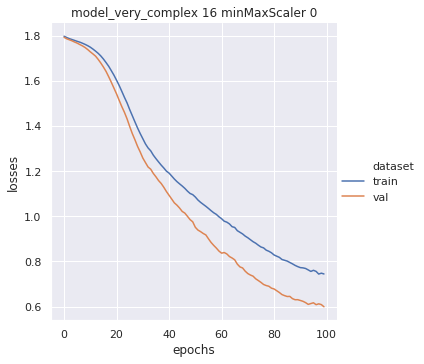

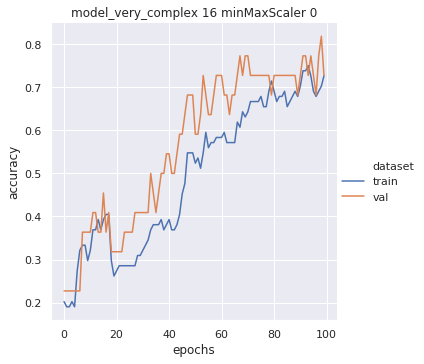

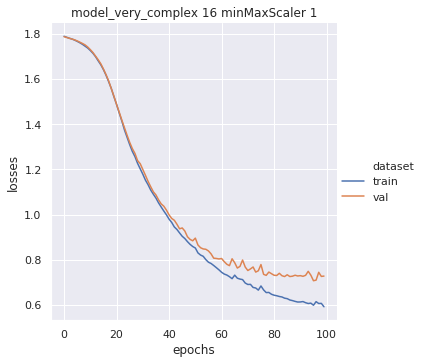

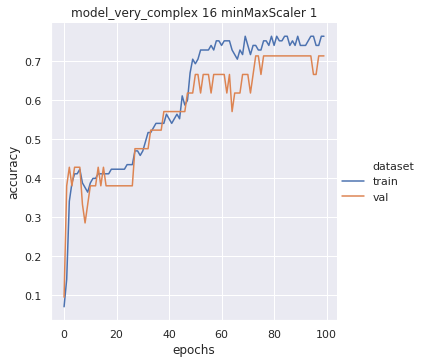

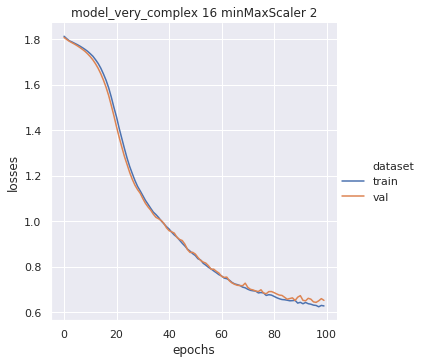

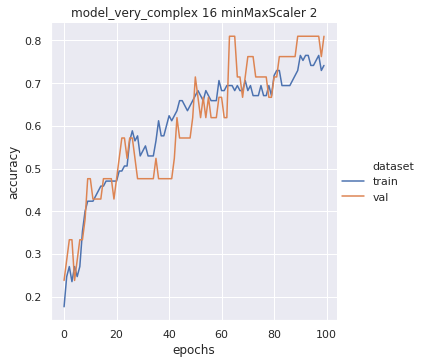

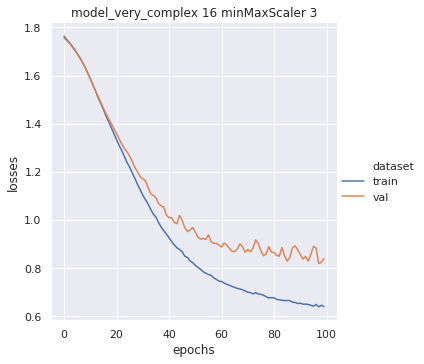

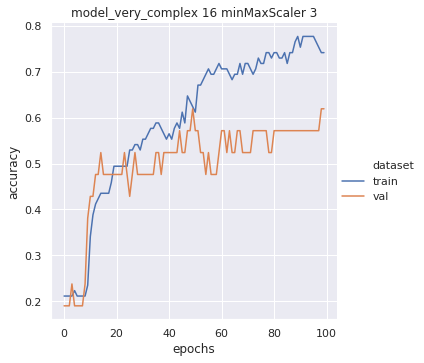

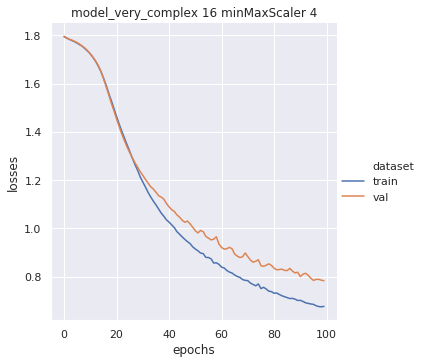

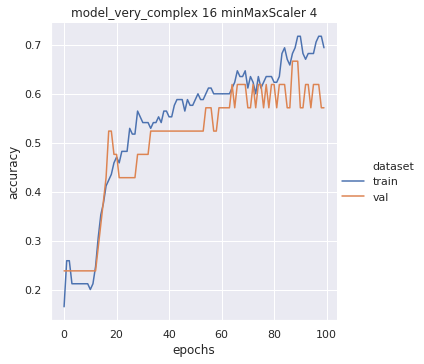

1/1 ; 2/3 ; 1/3 ; 2/3 ; 1/1:  48%|████▊     | 13/27 [39:24<48:39, 208.51s/it]  

	minMaxScaler	16	0.8181818127632141	0.7255411386489868	0.07819096572038142


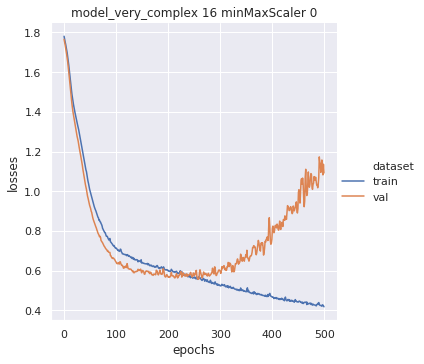

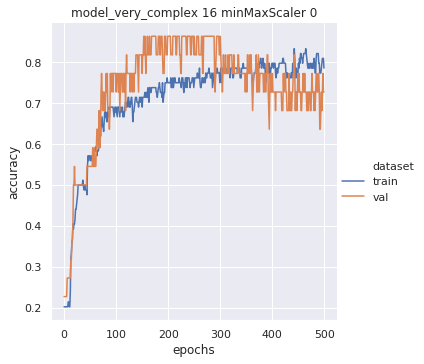

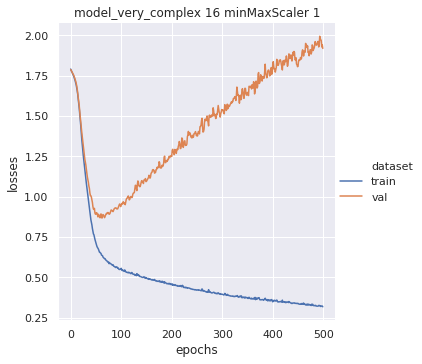

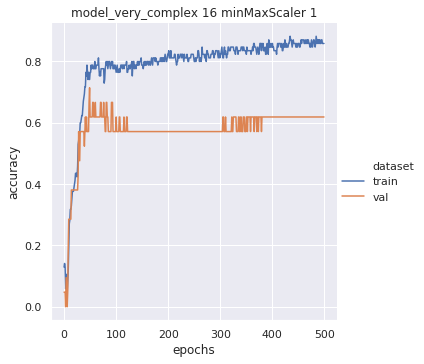

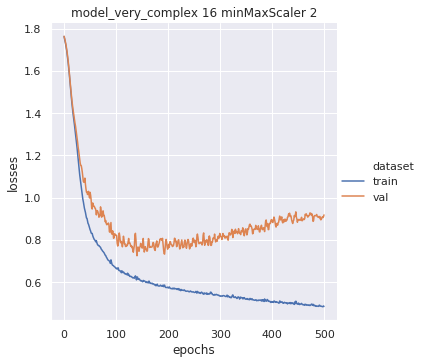

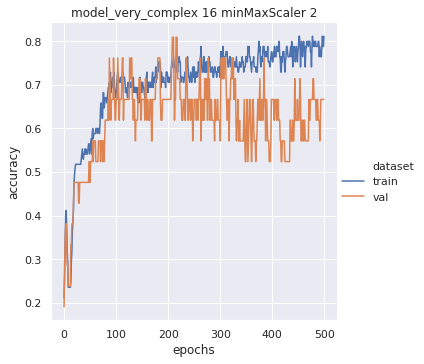

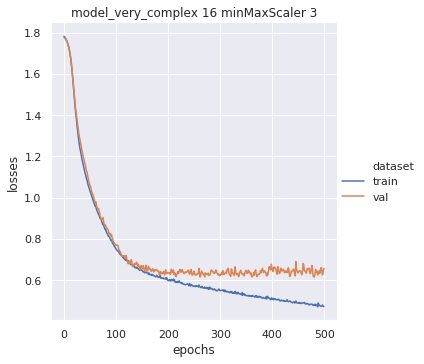

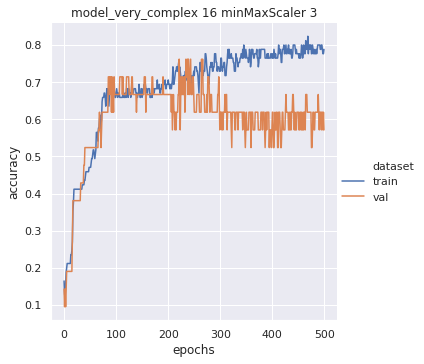

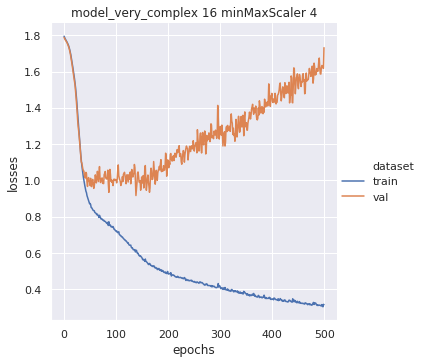

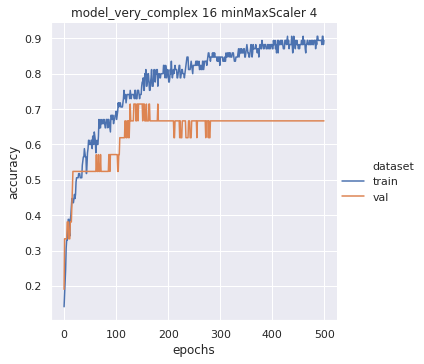

1/1 ; 2/3 ; 2/3 ; 2/3 ; 1/1:  52%|█████▏    | 14/27 [40:20<35:14, 162.65s/it]

	minMaxScaler	16	0.8636363744735718	0.7727272868156433	0.0575611061299671


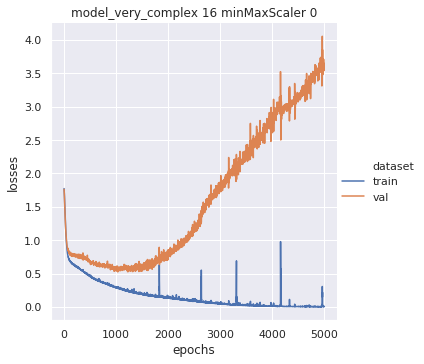

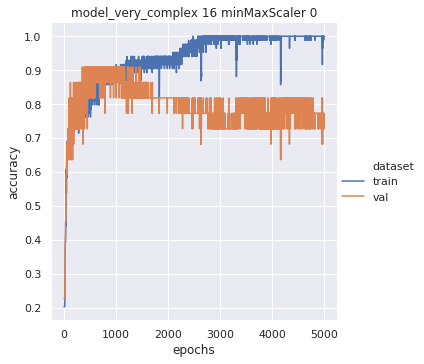

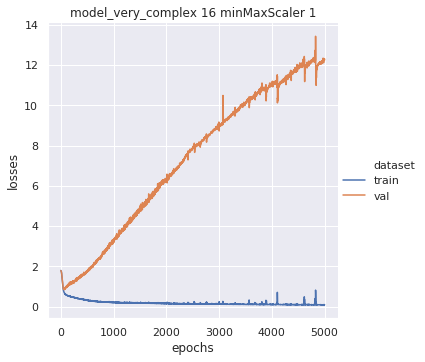

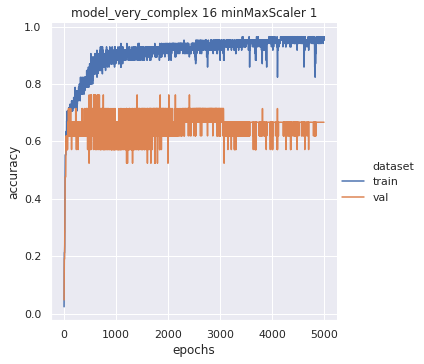

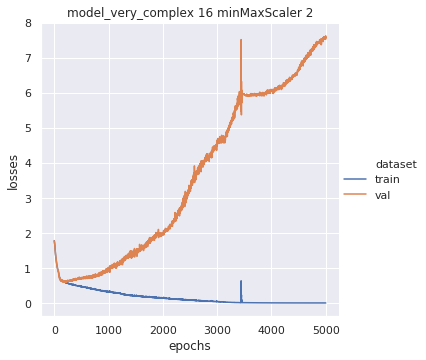

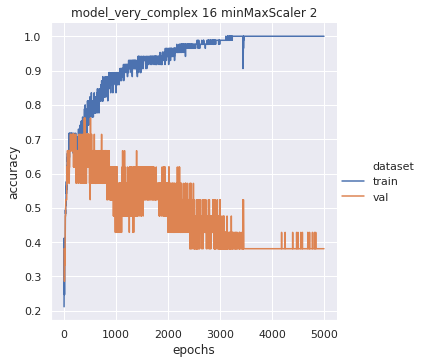

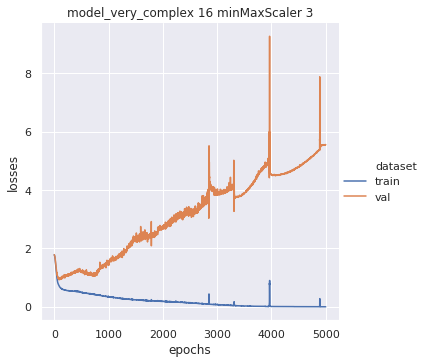

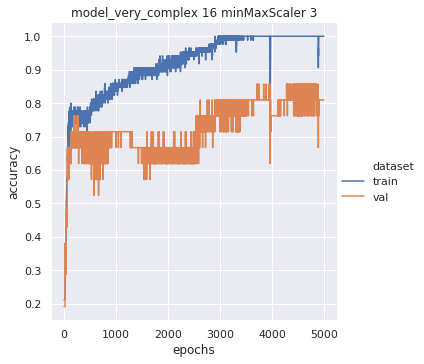

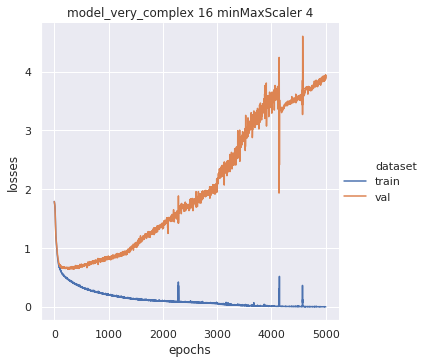

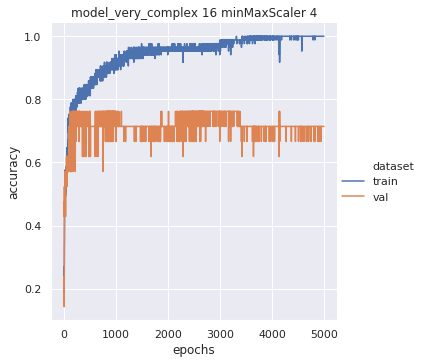

1/1 ; 2/3 ; 3/3 ; 2/3 ; 1/1:  56%|█████▌    | 15/27 [47:06<47:09, 235.75s/it]

	minMaxScaler	16	0.9090909361839294	0.8103896260261536	0.06161194050030349


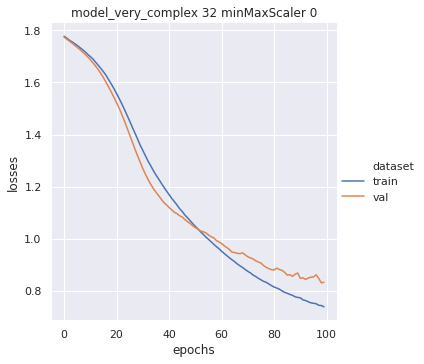

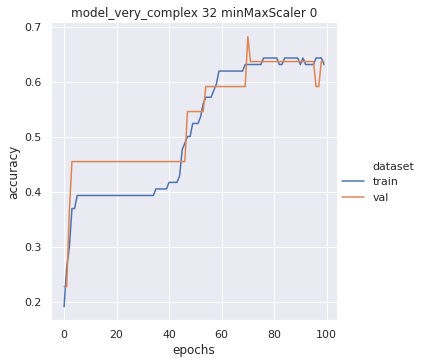

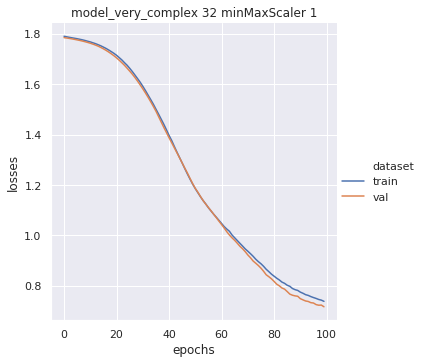

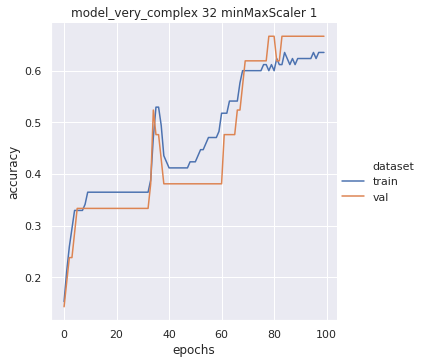

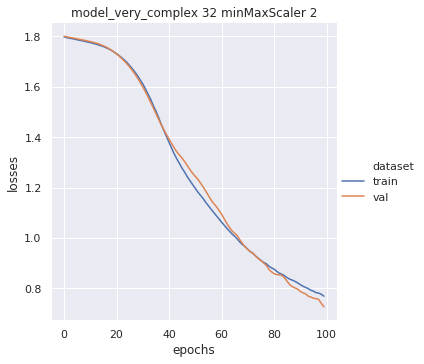

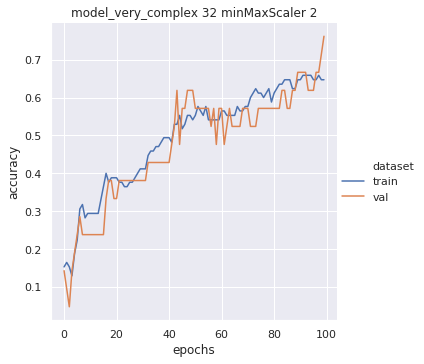

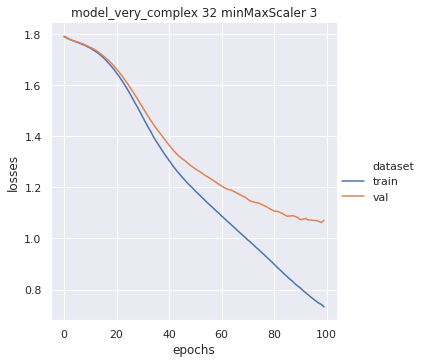

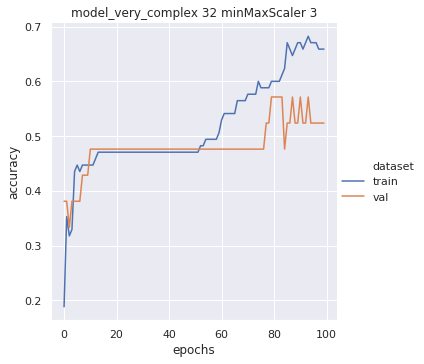

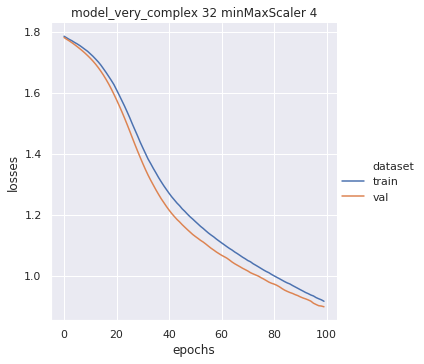

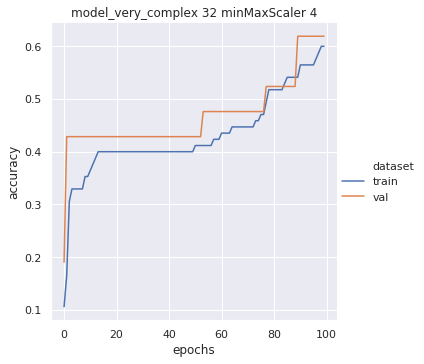

1/1 ; 3/3 ; 1/3 ; 2/3 ; 1/1:  59%|█████▉    | 16/27 [47:31<31:37, 172.49s/it]

	minMaxScaler	32	0.761904776096344	0.6601731777191162	0.06391697821749906


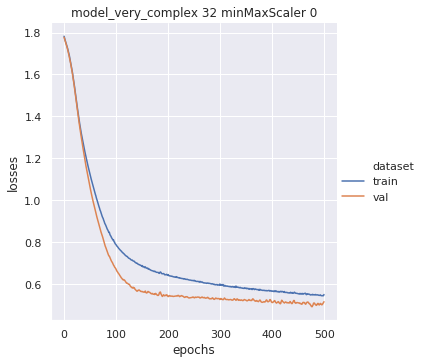

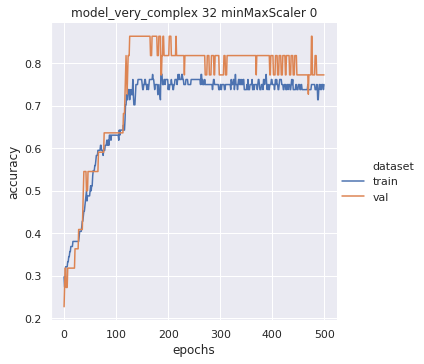

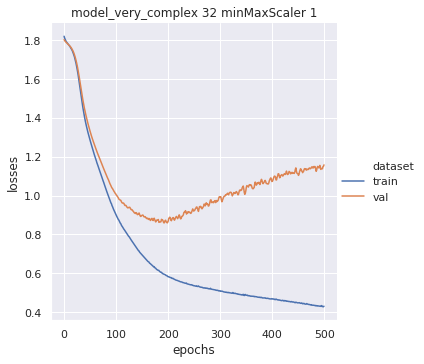

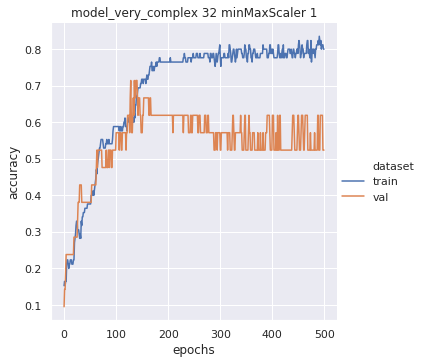

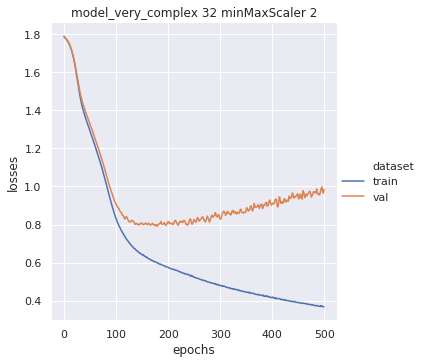

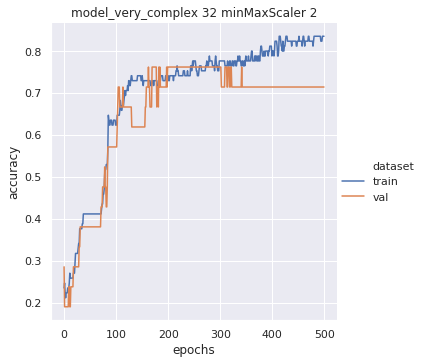

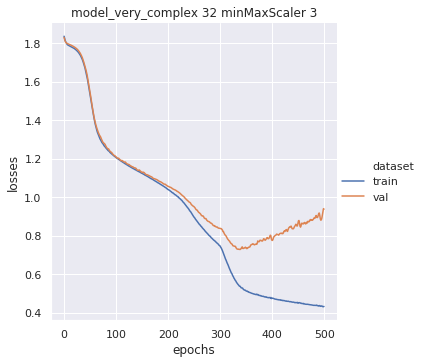

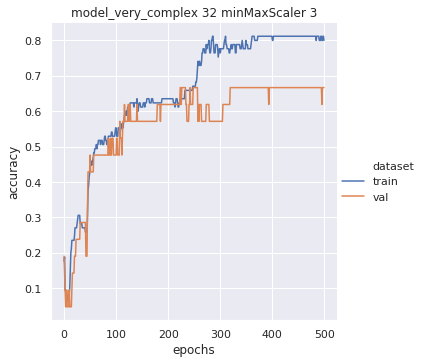

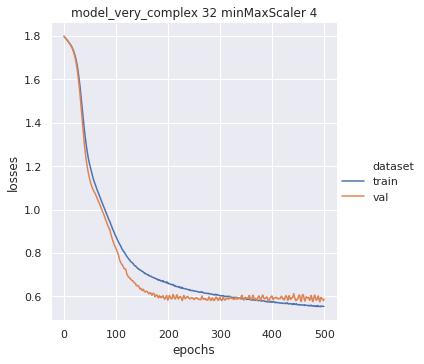

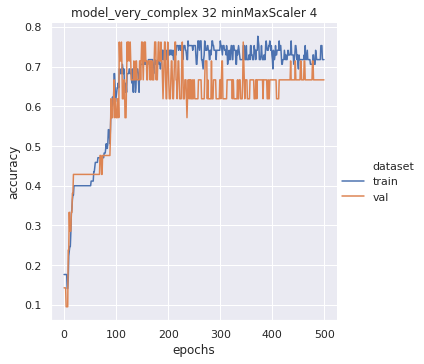

1/1 ; 3/3 ; 2/3 ; 2/3 ; 1/1:  63%|██████▎   | 17/27 [48:25<22:49, 136.91s/it]

	minMaxScaler	32	0.8636363744735718	0.7536796689033508	0.06534358927370129


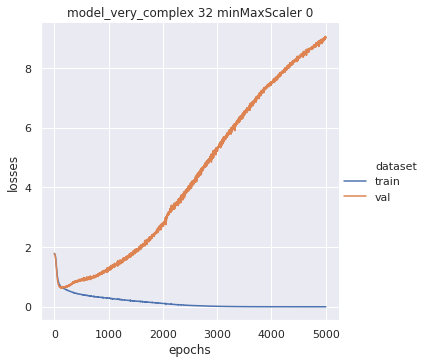

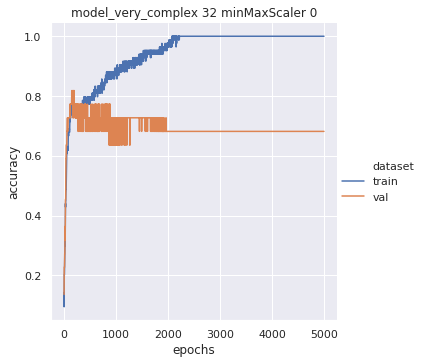

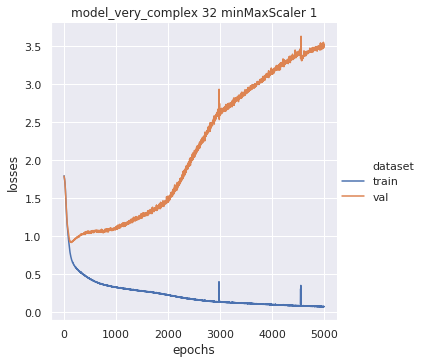

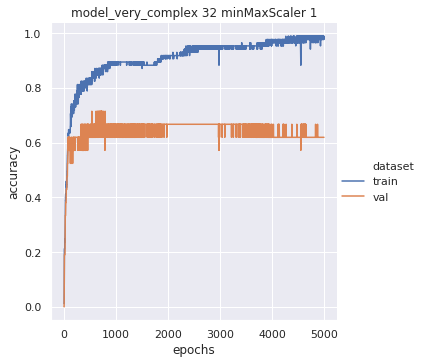

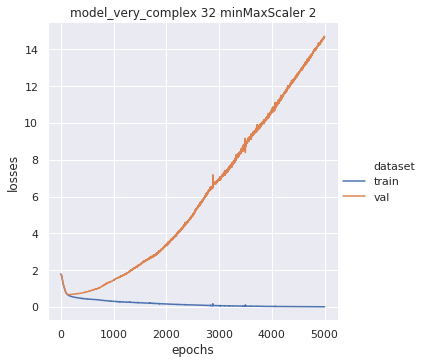

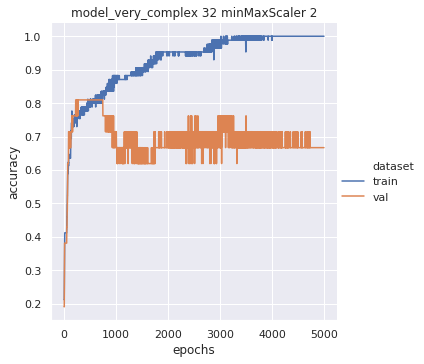

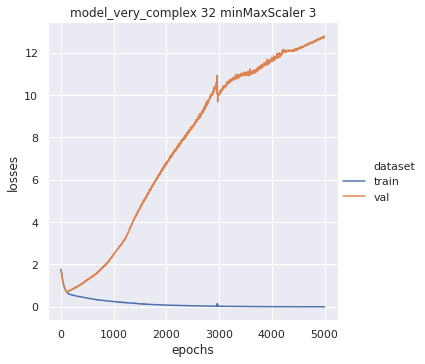

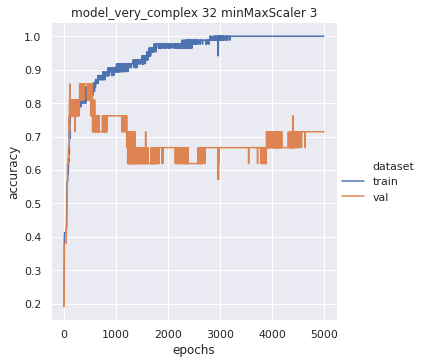

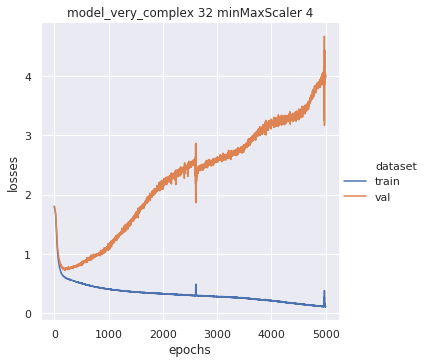

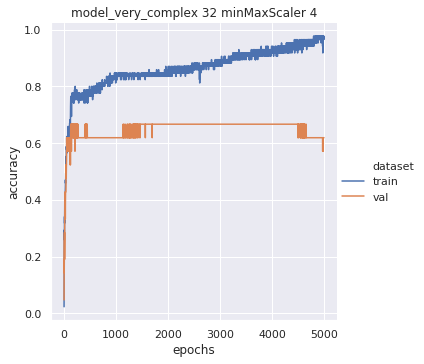

1/1 ; 3/3 ; 3/3 ; 2/3 ; 1/1:  67%|██████▋   | 18/27 [52:11<24:32, 163.60s/it]

	minMaxScaler	32	0.8571428656578064	0.773160183429718	0.07100622246408582


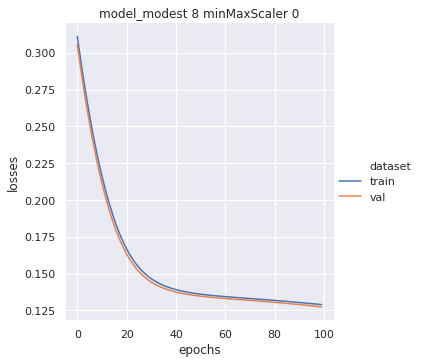

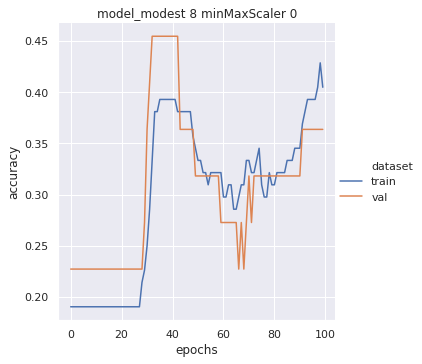

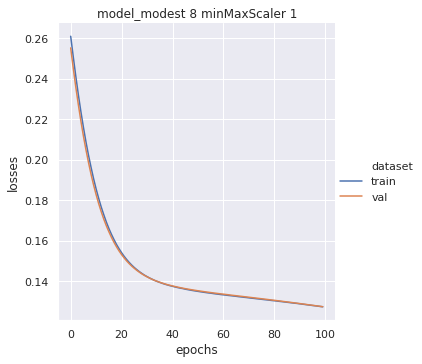

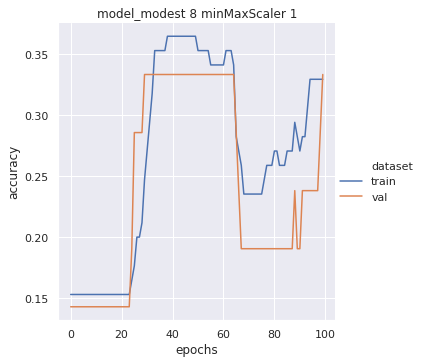

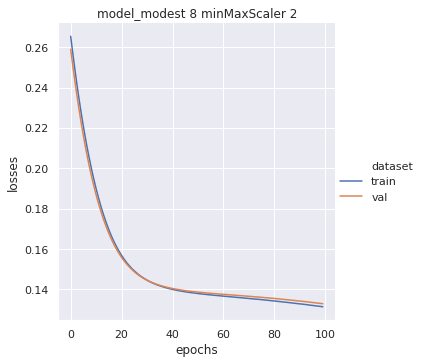

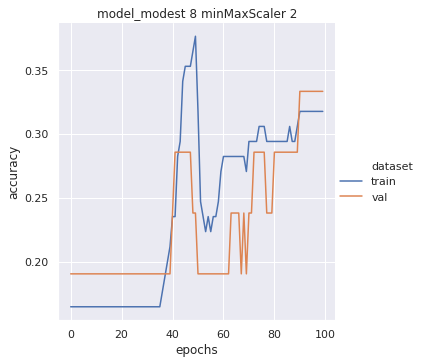

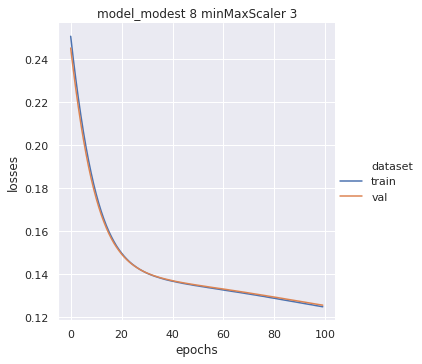

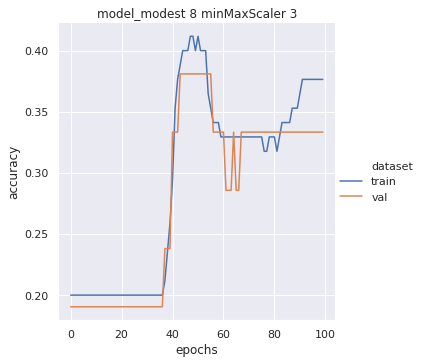

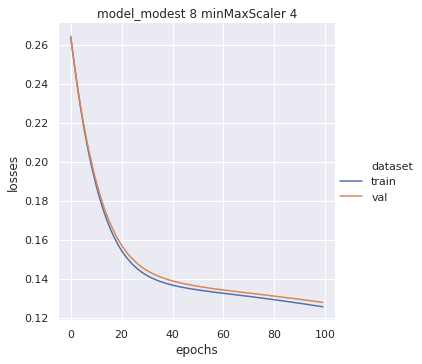

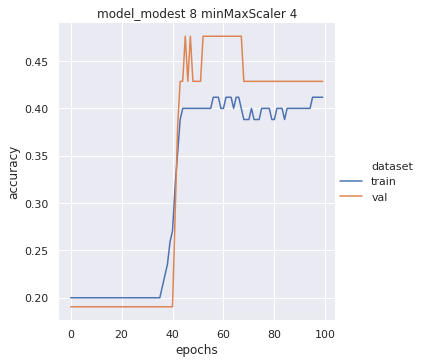

1/1 ; 1/3 ; 1/3 ; 3/3 ; 1/1:  70%|███████   | 19/27 [52:33<16:10, 121.35s/it]

	minMaxScaler	8	0.4761904776096344	0.39567100405693056	0.05989690092023354


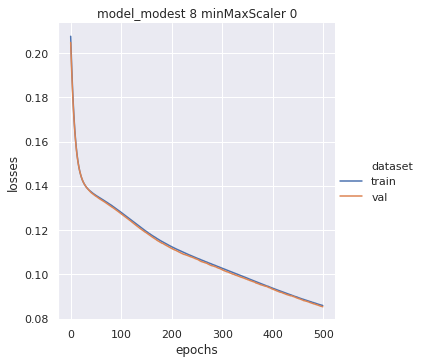

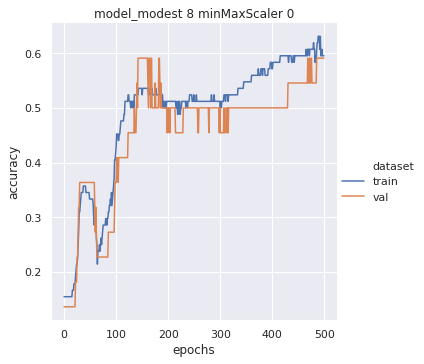

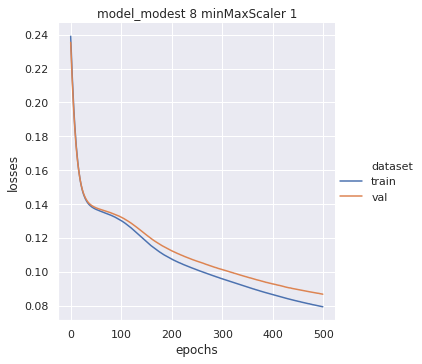

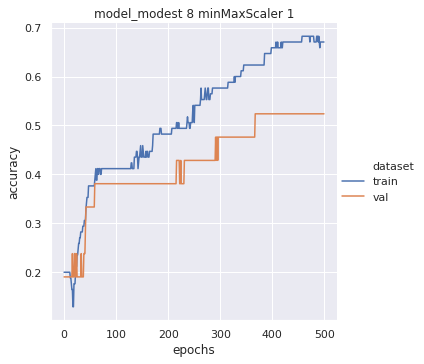

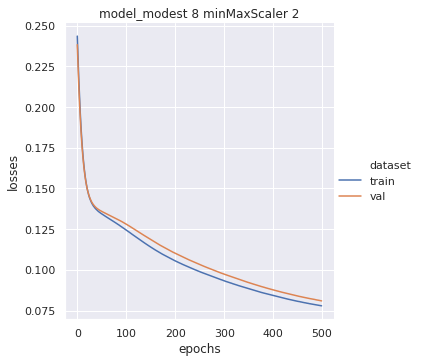

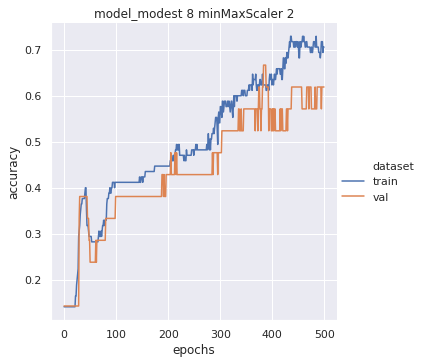

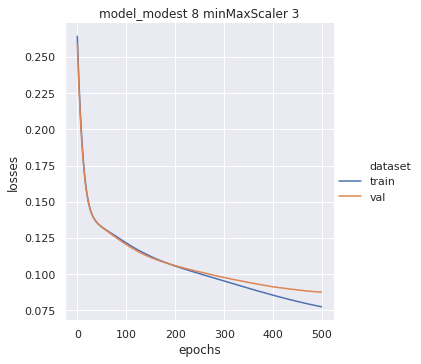

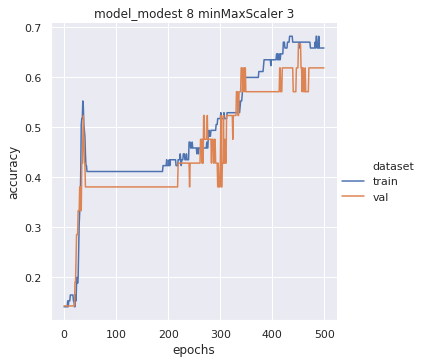

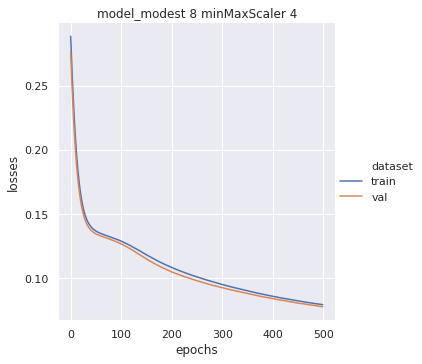

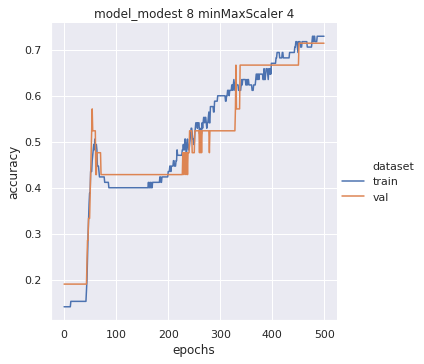

1/1 ; 1/3 ; 2/3 ; 3/3 ; 1/1:  74%|███████▍  | 20/27 [54:00<12:56, 111.00s/it]

	minMaxScaler	8	0.7142857313156128	0.6324675440788269	0.06718190967016484


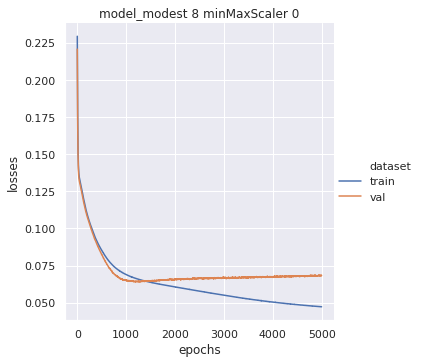

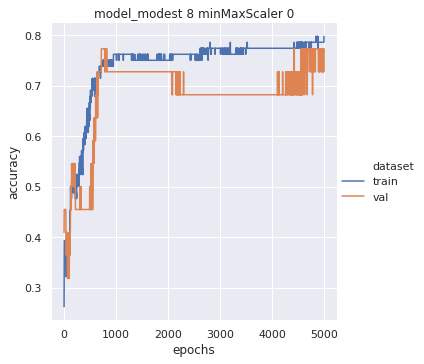

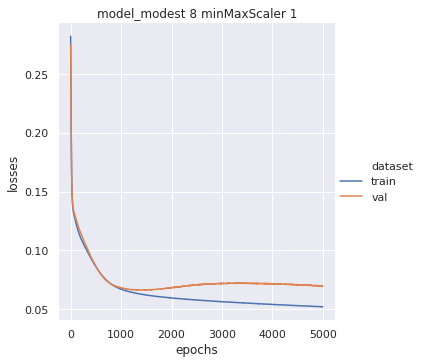

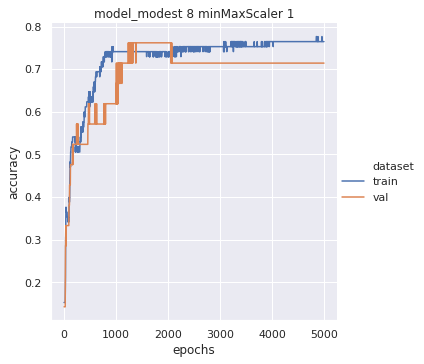

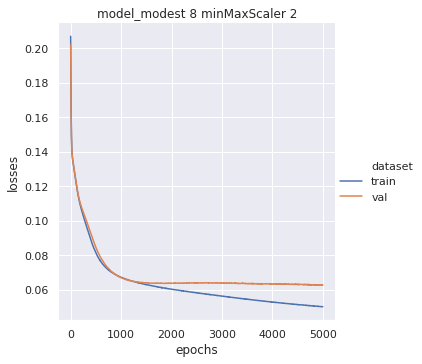

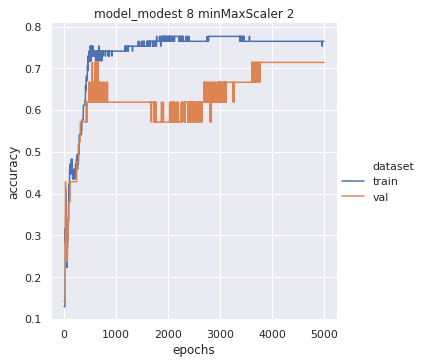

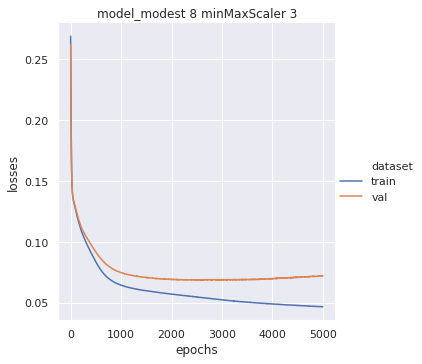

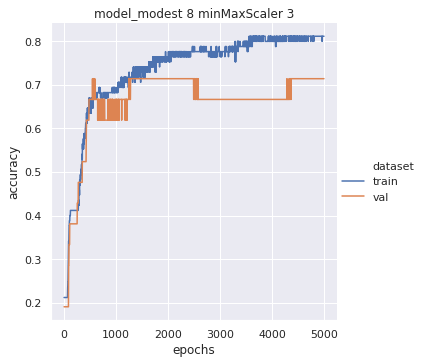

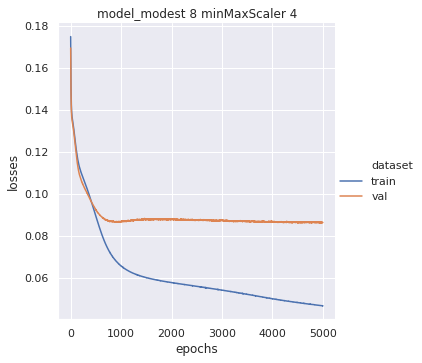

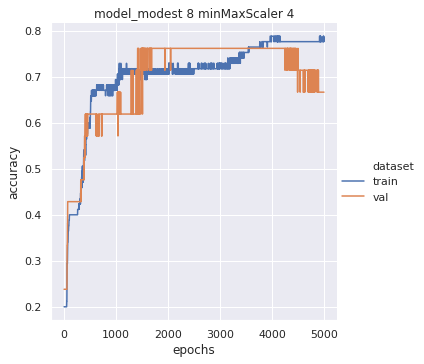

1/1 ; 1/3 ; 3/3 ; 3/3 ; 1/1:  78%|███████▊  | 21/27 [1:03:43<25:15, 252.57s/it]

	minMaxScaler	8	0.7727272510528564	0.745021653175354	0.02540501374932365


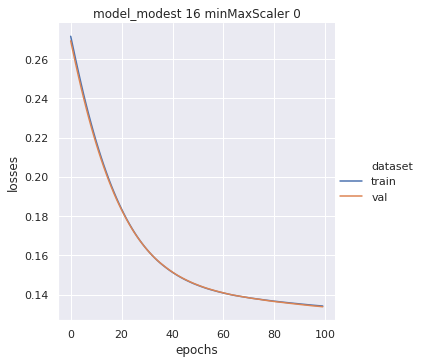

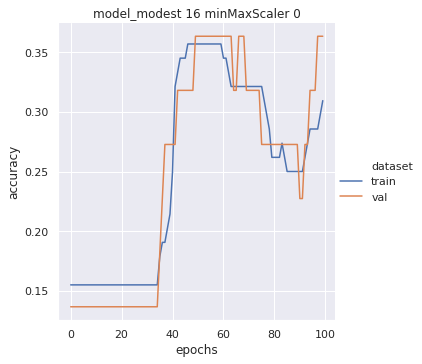

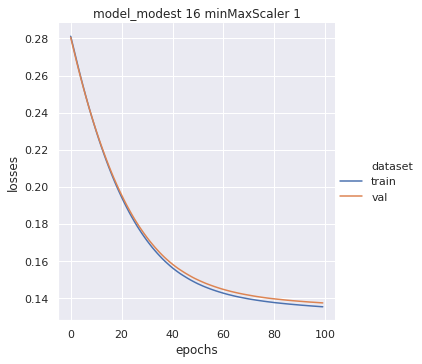

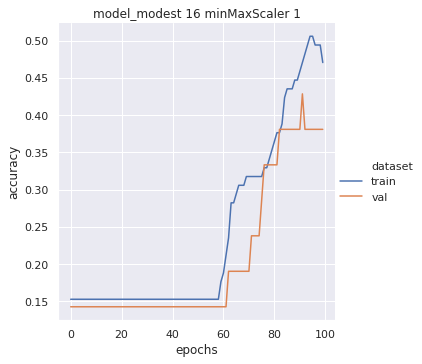

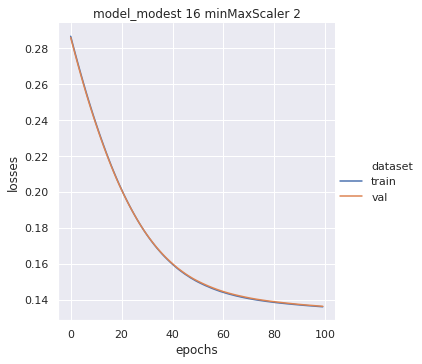

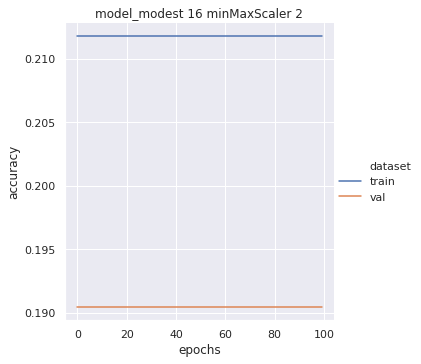

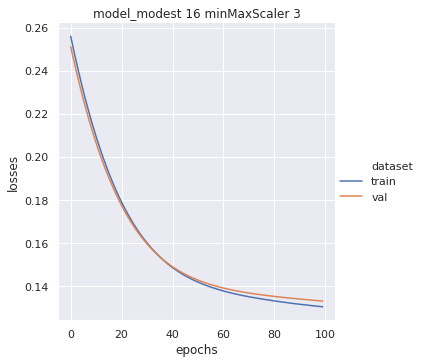

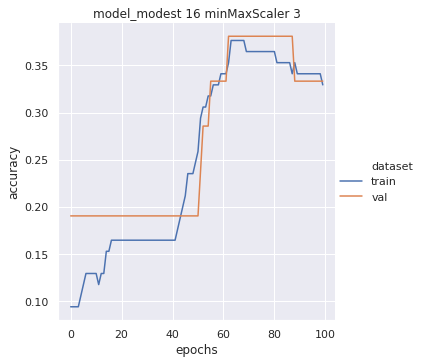

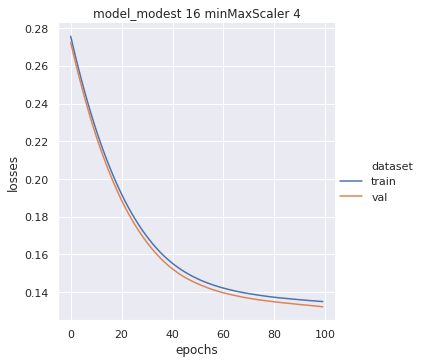

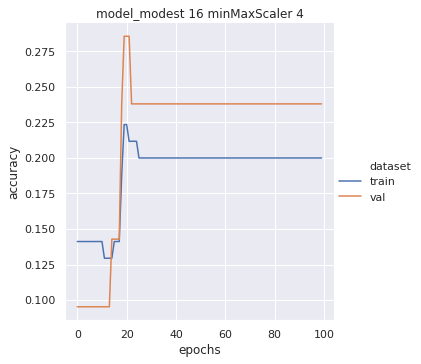

1/1 ; 2/3 ; 1/3 ; 3/3 ; 1/1:  81%|████████▏ | 22/27 [1:04:02<15:12, 182.53s/it]

	minMaxScaler	16	0.4285714328289032	0.3298701375722885	0.08351276594241017


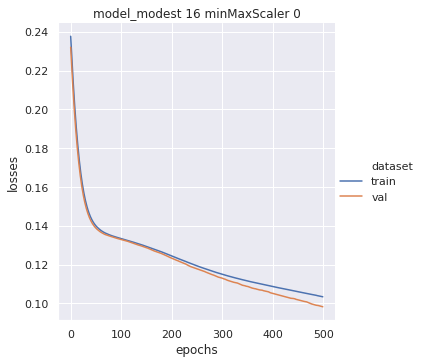

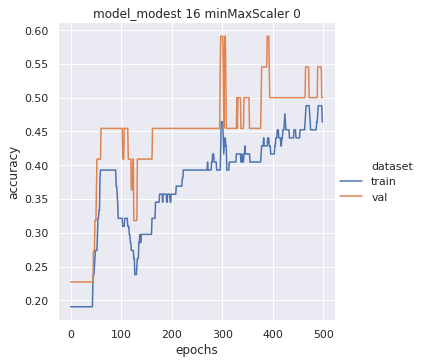

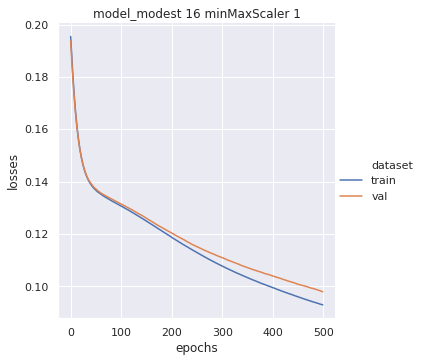

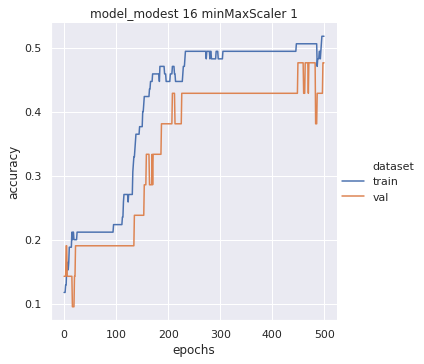

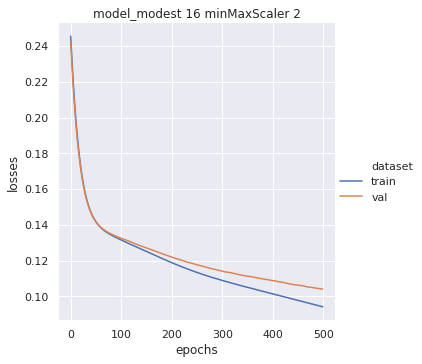

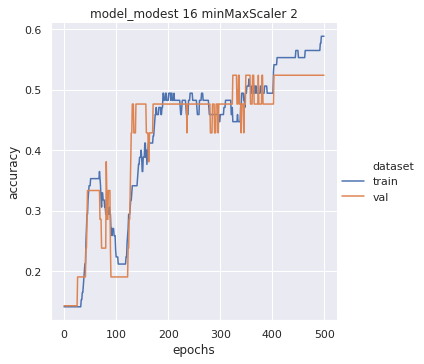

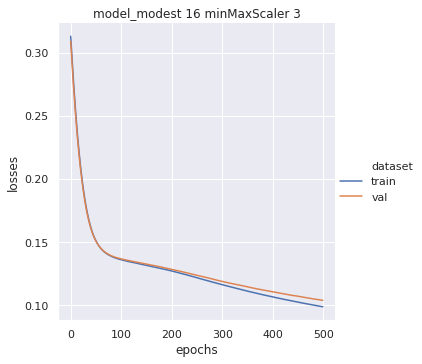

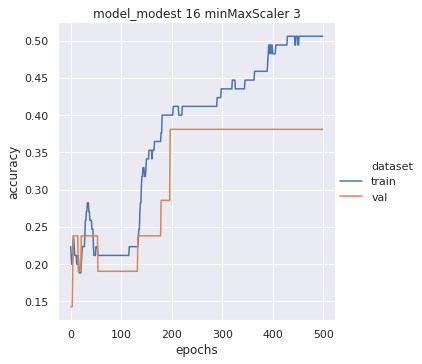

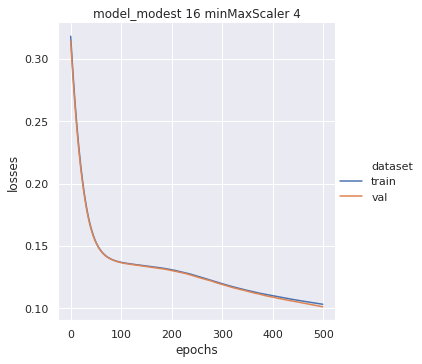

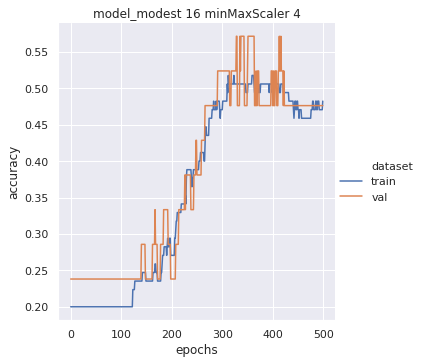

1/1 ; 2/3 ; 2/3 ; 3/3 ; 1/1:  85%|████████▌ | 23/27 [1:05:17<10:00, 150.25s/it]

	minMaxScaler	16	0.5909090638160706	0.5086580157279968	0.07523007139605944


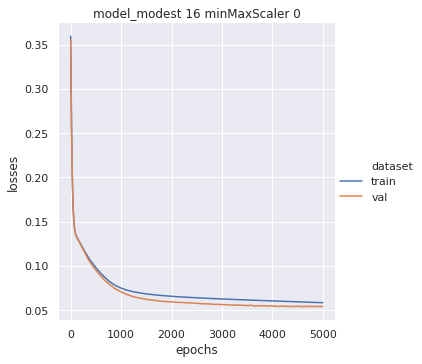

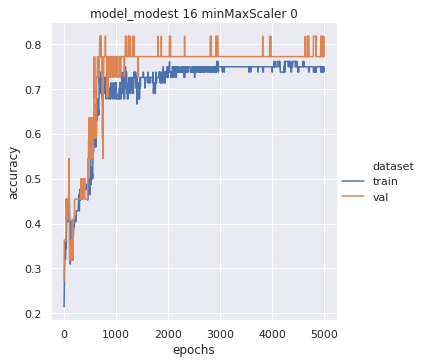

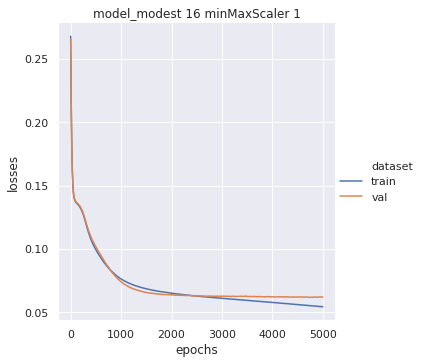

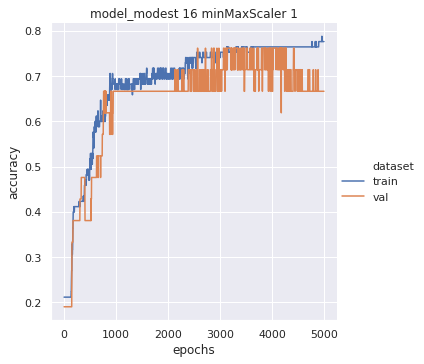

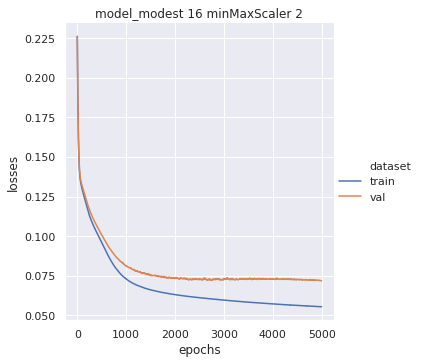

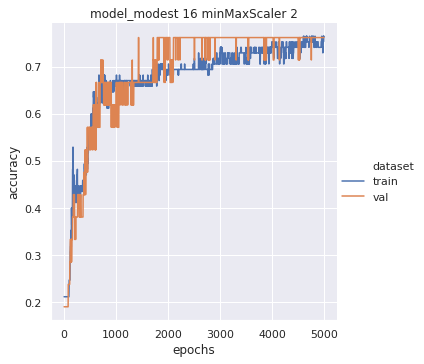

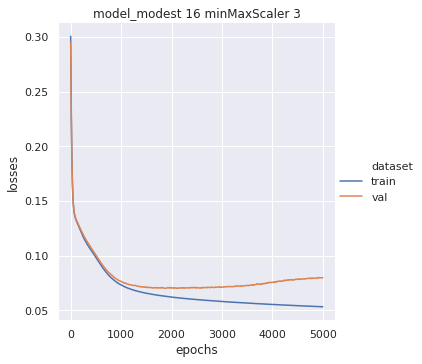

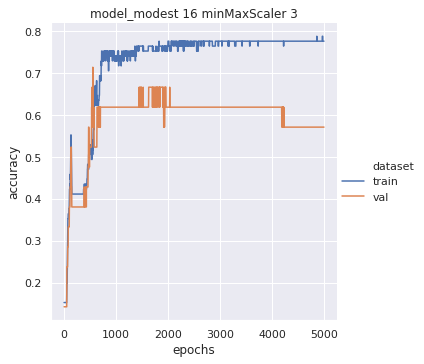

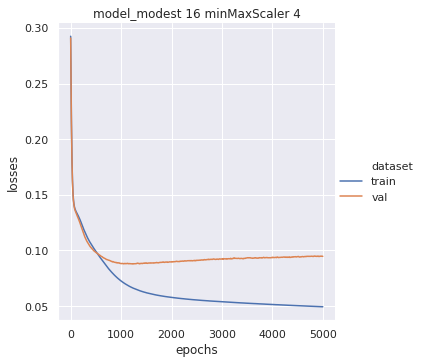

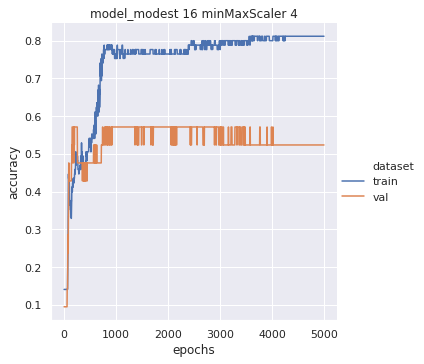

1/1 ; 2/3 ; 3/3 ; 3/3 ; 1/1:  89%|████████▉ | 24/27 [1:11:54<11:12, 224.25s/it]

	minMaxScaler	16	0.8181818127632141	0.7255411386489868	0.08379055132064459


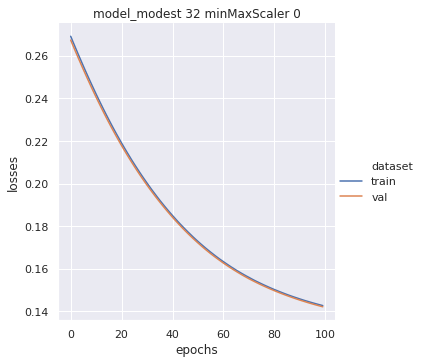

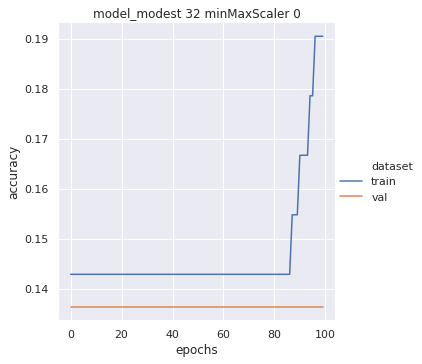

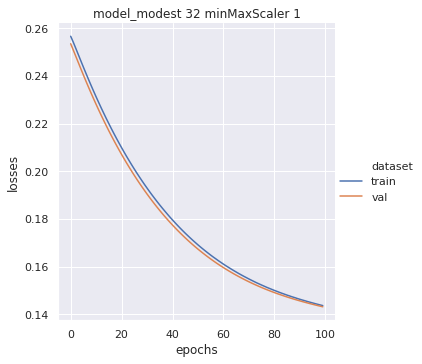

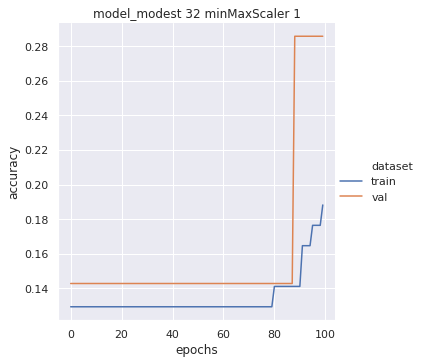

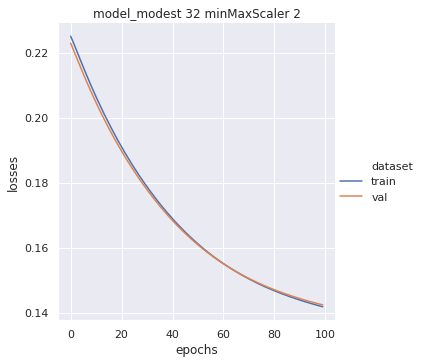

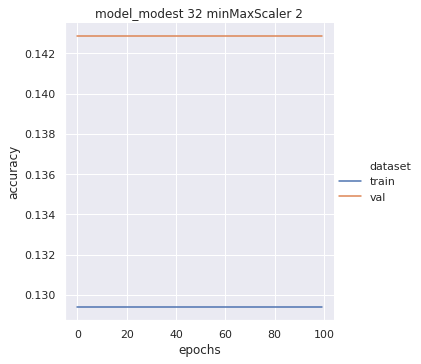

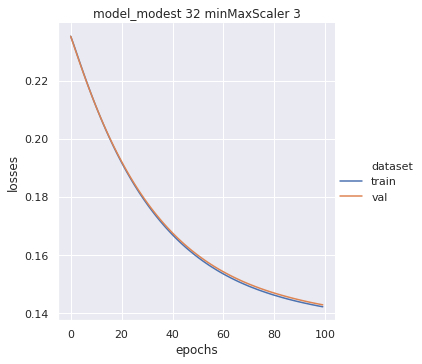

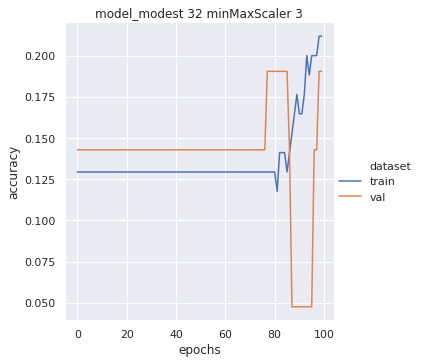

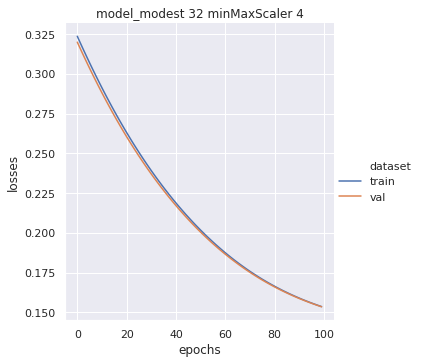

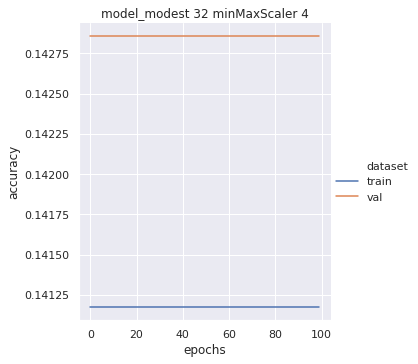

1/1 ; 3/3 ; 1/3 ; 3/3 ; 1/1:  93%|█████████▎| 25/27 [1:12:11<05:24, 162.09s/it]

	minMaxScaler	32	0.2857142984867096	0.17965368628501893	0.05647650570142429


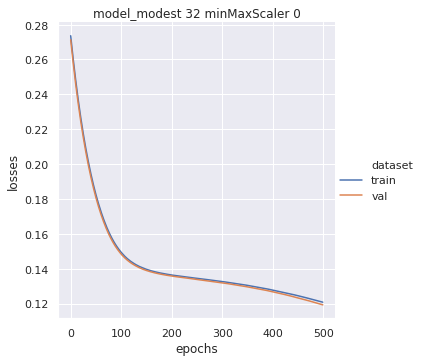

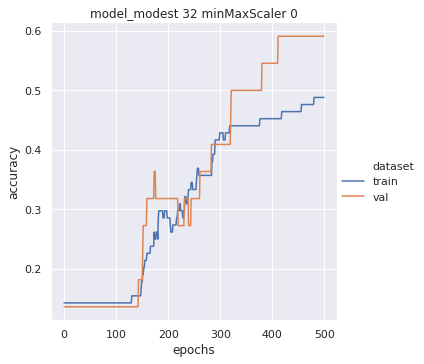

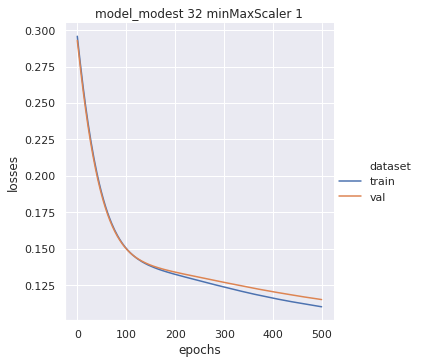

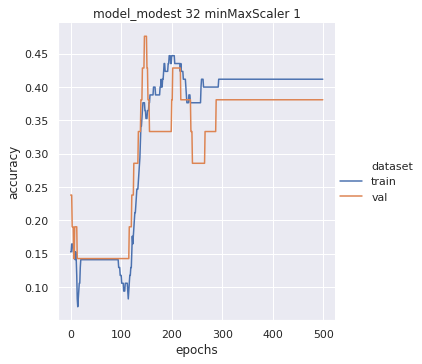

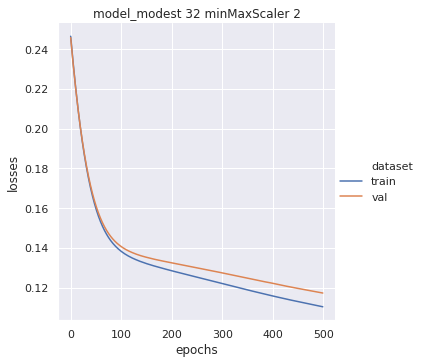

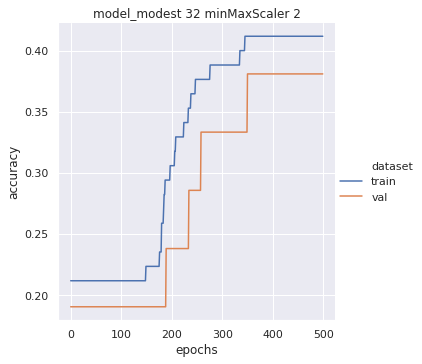

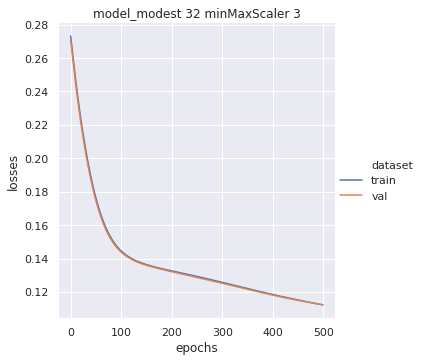

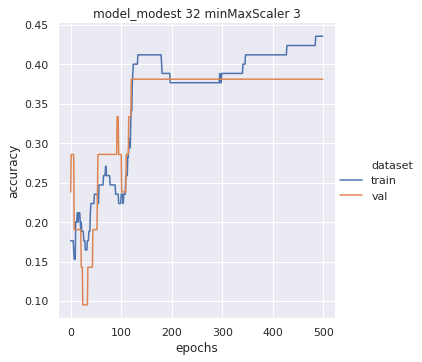

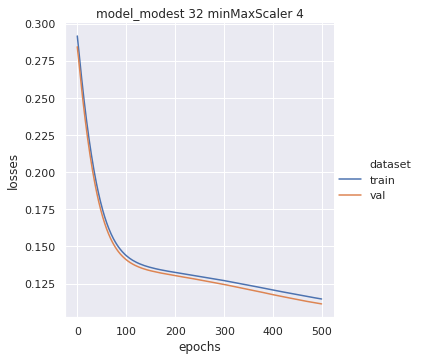

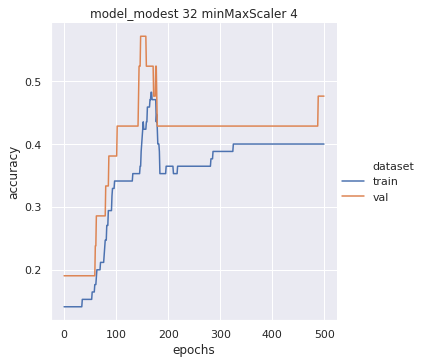

1/1 ; 3/3 ; 2/3 ; 3/3 ; 1/1:  96%|█████████▋| 26/27 [1:13:06<02:10, 130.02s/it]

	minMaxScaler	32	0.5909090638160706	0.4800865828990936	0.08977231491462782


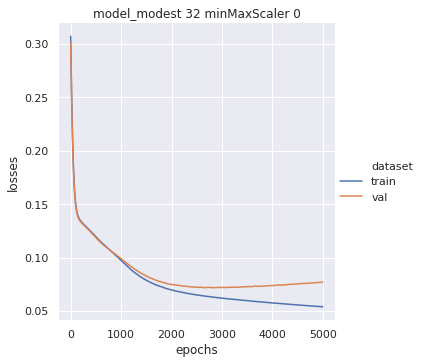

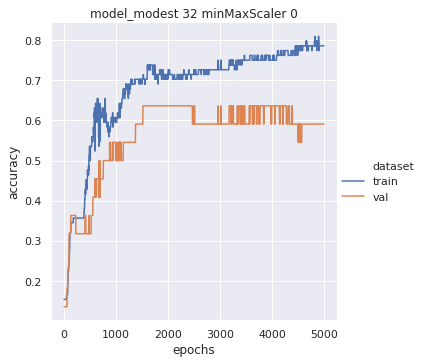

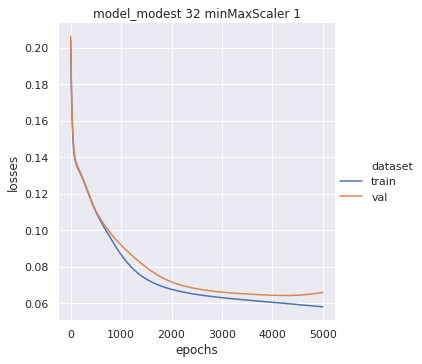

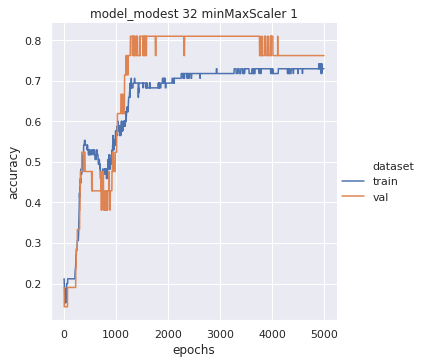

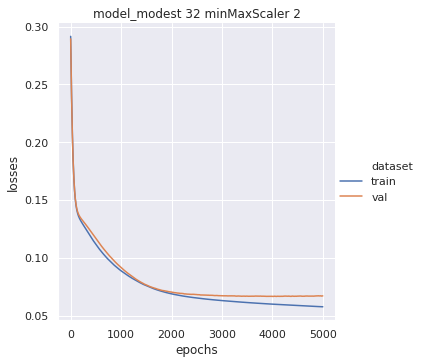

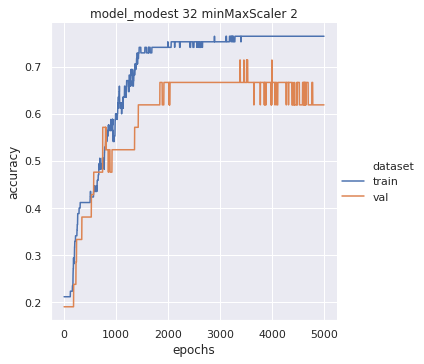

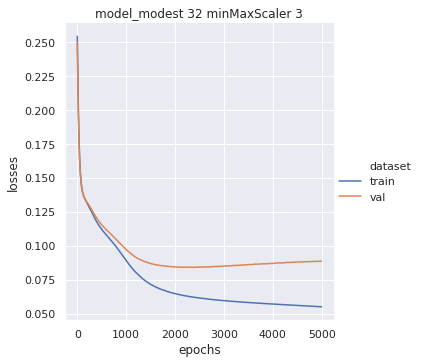

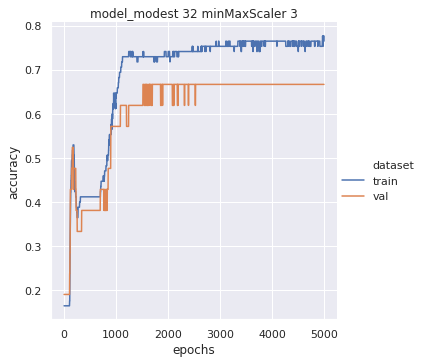

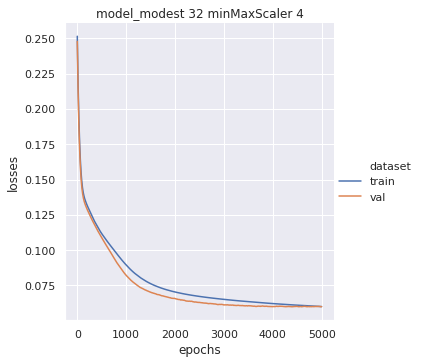

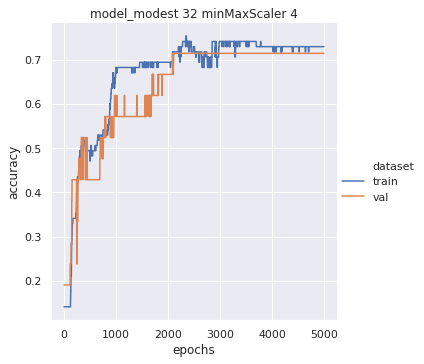

1/1 ; 3/3 ; 3/3 ; 3/3 ; 1/1: 100%|██████████| 27/27 [1:18:17<00:00, 184.17s/it]

	minMaxScaler	32	0.8095238208770752	0.7082251191139222	0.05869593955031452

Mejores resultados con los parametros:

      scaler:                    minMaxScaler
      batch:                     8
      epoch:                     500
      model:                     model_complex
      cross_validation:          5



In [12]:
pbar = tqdm(total=len(scalers) * len(batchs) * len(epochs) * len(models) *
            len(cross_validations))

best_acc = -1
best_path = ''
features = []
for m, model in enumerate(models):
  for s, scaler_function in enumerate(scalers):
    for b, batch in enumerate(batchs):
      for e, epoch in enumerate(epochs):
        for c, cross_validation in enumerate(cross_validations):
          scaler, x_train = scaler_function(X_train)

          kfold = StratifiedKFold(n_splits=cross_validation, shuffle=True)

          results = []

          for index_kfold, [index_t, index_v] in enumerate(kfold.split(x_train, np.argmax(y_train, 1))):
            name_model = './models/model_{}_{}_{}_{}.h5'.format(
              str(index_kfold), model.__name__, scaler_function.__name__, batch)

            callbacks = [ModelCheckpoint(name_model, save_best_only=True)]
            model_to_train = model()
            history = model_to_train.fit(x_train[index_t], y_train[index_t],
                                validation_data=(x_train[index_v], y_train[index_v]),
                                epochs=epoch, batch_size=batch,
                                callbacks=callbacks, verbose=0)
            new_model_name = name_model[:-3] + '-' + str(np.max(history.history['val_loss'])) + '-' + '.h5'
            shutil.move(name_model, new_model_name)

            results.append(np.max(history.history['val_acc']))

            plot_history(history, '{} {} {} {}'.format(model.__name__, batch,
                                                       scaler_function.__name__, 
                                                       index_kfold))
            K.clear_session()

          results = np.array(results)

          print('\t{0}\t{1}\t{2}\t{3}\t{4}'.format(scaler_function.__name__,
                                                   batch,
                                                   results.max(), results.mean(),
                                                   results.std()))

          pbar.set_description('{}/{} ; {}/{} ; {}/{} ; {}/{} ; {}/{}'.format(
            s + 1, len(scalers),
            b + 1, len(batchs),
            e + 1, len(epochs),
            m + 1, len(models),
            c + 1, len(cross_validations),
            ))
          # print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))
          pbar.update(1)
          if best_acc < np.max(history.history['val_acc']):
              best_acc = np.max(history.history['val_acc'])
              best_path = new_model_name
              features = scaler_function, batch, epoch, model, cross_validation



scaler_function, batch, epoch, model, cross_validation = features
print('''
Mejores resultados con los parametros:

      scaler:                    {}
      batch:                     {}
      epoch:                     {}
      model:                     {}
      cross_validation:          {}
'''.format(scaler_function.__name__, batch, epoch, model.__name__, cross_validation))


# Revision de la mejor red
 Se realiza nuevamente el entrenamiento sin k-fold para obtener su historial
 para visualizarlo

In [14]:
X = scaler_function(X_test)

model = load_model(best_path)

#Confution Matrix and Classification Report
Y_pred = model.predict(X)
Y_pred = numpy.argmax(Y_pred, axis=-1)

y_hat = np.argmax(y_test, -1)
# y_pred_decode = le.inverse_transform(y_pred)

print('''Confusion Matrix

{}

Classification Report

{}'''.format(confusion_matrix(Y_pred, y_hat),
classification_report(Y_pred, y_hat, target_names=list(set(target_names)))))


OSError: Unable to open file (unable to open file: name = './models/model_4_model_complex_minMaxScaler_8.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [15]:
K.clear_session()